In [1]:
import pandas as pd
import numpy as np
import os
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Parameters

In [2]:
# this cell is tagged `parameters` and will be overridden by papermill
sample_name = "1904_C7_cond_1_HTO"
workflow_id = "08778704-c763-4145-a951-b8af53cc45cc"
path_data = os.path.join("./data/", sample_name, workflow_id)

## Run Report

In [3]:
!cat $path_data/report/run_report.yaml

Date: 2020-07-17
Running time: 1.0 hour, 25.0 minutes, 15.75 seconds
CITE-seq-Count Version: 1.4.3
Reads processed: 56902257
Percentage mapped: 94
Percentage unmapped: 6
Uncorrected cells: 3
Correction:
	Cell barcodes collapsing threshold: 1
	Cell barcodes corrected: 95210
	UMI collapsing threshold: 1
	UMIs corrected: 477024
Run parameters:
	Read1_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/08778704-c763-4145-a951-b8af53cc45cc/call-TrimR1/R1.fastq.gz
	Read2_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/08778704-c763-4145-a951-b8af53cc45cc/call-TrimR2/R2.fastq.gz
	Cell barcode:
		First position: 1
		Last position: 16
	UMI barcode:
		First position: 17
		Last position: 28
	Expected cells: 0
	Tags max errors: 2
	Start trim: 0


In [4]:
with open(os.path.join(path_data, "report/run_report.yaml"), "rt") as fin:
    # report file contains tabs
    # run_report = yaml.load(fin, Loader=yaml.FullLoader)        
    run_report = fin.read().replace("\t", "  ")
    run_report = yaml.load(run_report, Loader=yaml.FullLoader)

## Classification

### Read

In [5]:
df_class = pd.read_csv(
    os.path.join(path_data, "final-classification.tsv.gz"),
    sep="\t",
    compression="gzip",
    index_col=0
)

In [6]:
df_class

,hashID
120703409084764,A0306
120703409154909,A0306
120703409343732,A0301
120703455028974,Doublet
120718456207715,A0306
...,...
241109193898332,A0306
241109220415709,A0306
241109239451037,A0306
241109239543707,A0306


In [7]:
df_class.shape

(2572, 1)

### Numeric to ACGT

In [8]:
from dna3bit import DNA3Bit

In [9]:
dna3bit = DNA3Bit()

In [10]:
new_index = df_class.index.map(lambda x: dna3bit.decode(x).decode())

In [11]:
df_class.index = new_index

In [12]:
df_class

,hashID
TTTATGCTCAAGAGTA,A0306
TTTATGCTCACCGGTG,A0306
TTTATGCTCGAACTCA,A0301
TTTATGCCATCCTTGC,Doublet
TTTAGTCAGACTAGAT,A0306
...,...
CCCAACTTCCGTAGTA,A0306
CCCAACTGTTCGATTG,A0306
CCCAACTCAATACCTG,A0306
CCCAACTCAACTTCTT,A0306


### Results

In [13]:
df_stats = df_class.groupby(by="hashID").size()
df_stats

hashID
A0301       745
A0302        21
A0303        25
A0304        16
A0305        40
A0306      1660
Doublet      65
dtype: int64

In [14]:
df_stats.sum()

2572

In [15]:
# sum excluding doublets
df_stats[ df_stats.index != "Doublet" ].sum()

2507

### Pie Chart

In [16]:
labels = [label.upper() if label != "Doublet" else "Doublet/Negative" for label in df_stats.index]
labels

['A0301', 'A0302', 'A0303', 'A0304', 'A0305', 'A0306', 'Doublet/Negative']

#### Pie 1

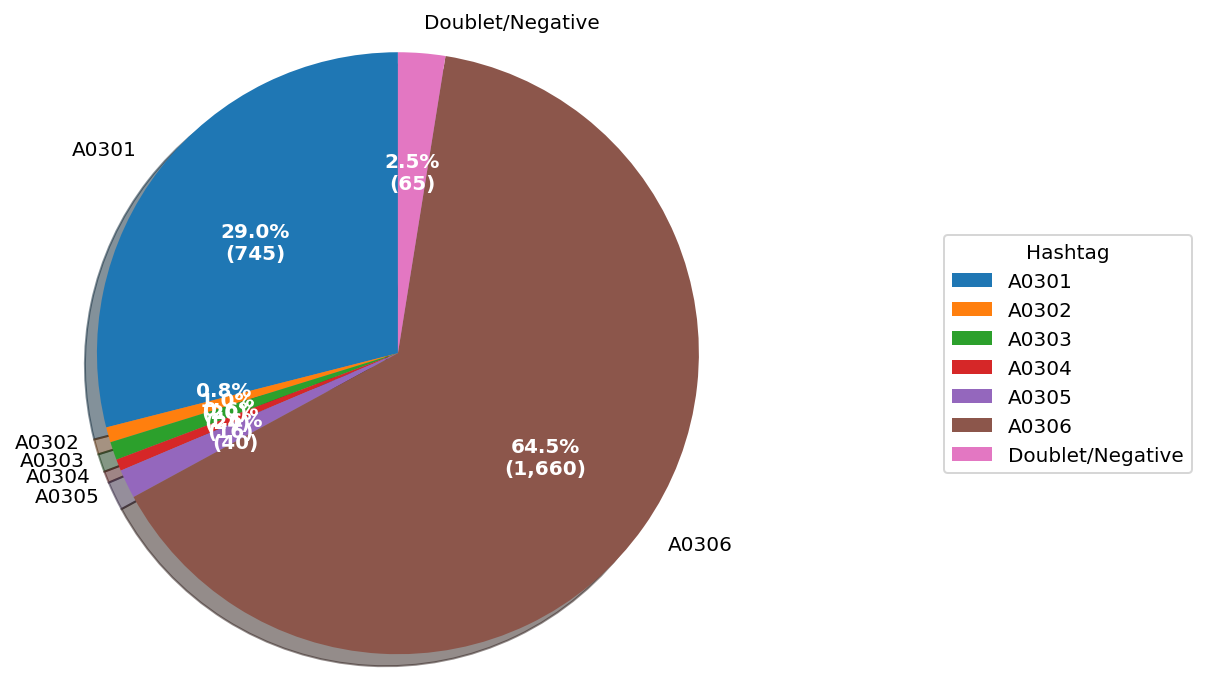

In [17]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

wedges, _, autotexts = ax.pie(
    df_stats,
    labels=labels,
    autopct=lambda pct: func_autopct(pct, df_stats),    
    shadow=True, startangle=90
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    loc="center left",
    bbox_to_anchor=(1.3, 0.0, 0.5, 1)
)

plt.show()

#### Pie 2

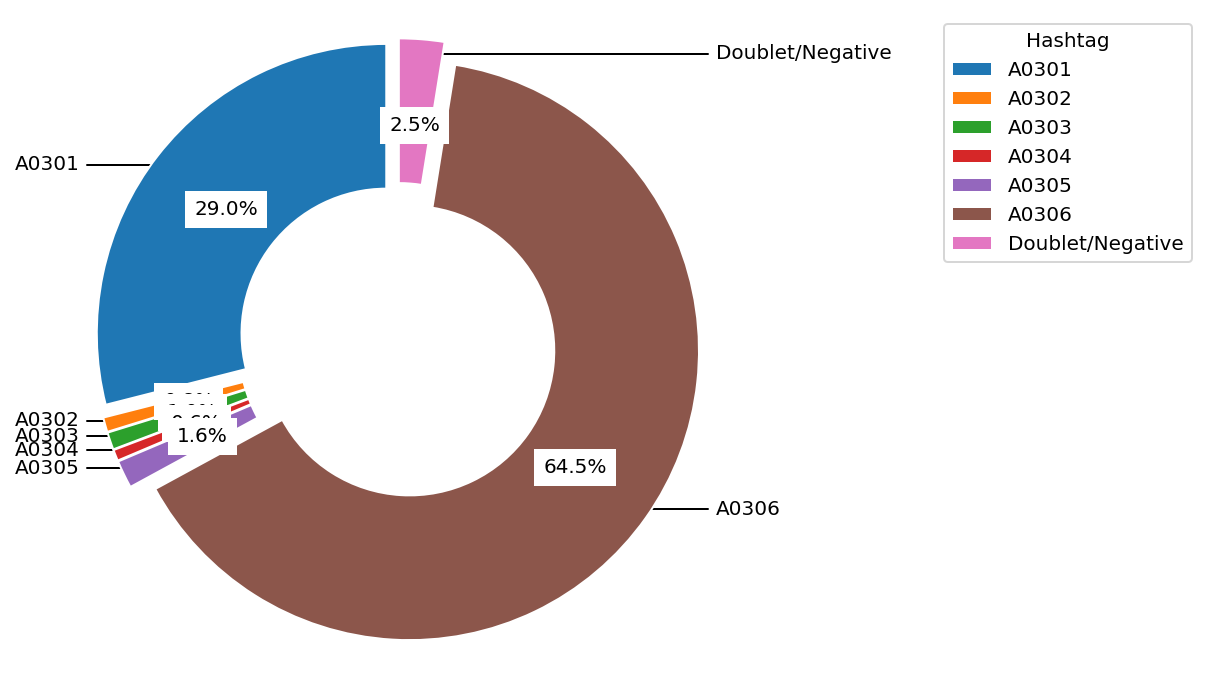

In [18]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

cmap = plt.get_cmap("tab20c")

wedges, _, autotexts = ax.pie(
    df_stats,
    explode=[0.05] * len(df_stats),
    wedgeprops=dict(width=0.5, edgecolor='w'),
    autopct='%1.1f%%',
    pctdistance=0.7,
    shadow=False,
    startangle=90,
    rotatelabels=True
)

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        labels[i], xy=(x, y), xytext=(1.1 * np.sign(x), y),
        horizontalalignment=horizontalalignment, **kw
    )

for i, autotext in enumerate(autotexts):
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_rotation(0)
    autotext.set_backgroundcolor("white")
    
ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    bbox_to_anchor=(1.2, 0.0, 0.5, 1)
)

plt.show()

### Distribution

In [19]:
df_dist = df_stats.drop(labels=["Doublet"])
df_dist

hashID
A0301     745
A0302      21
A0303      25
A0304      16
A0305      40
A0306    1660
dtype: int64

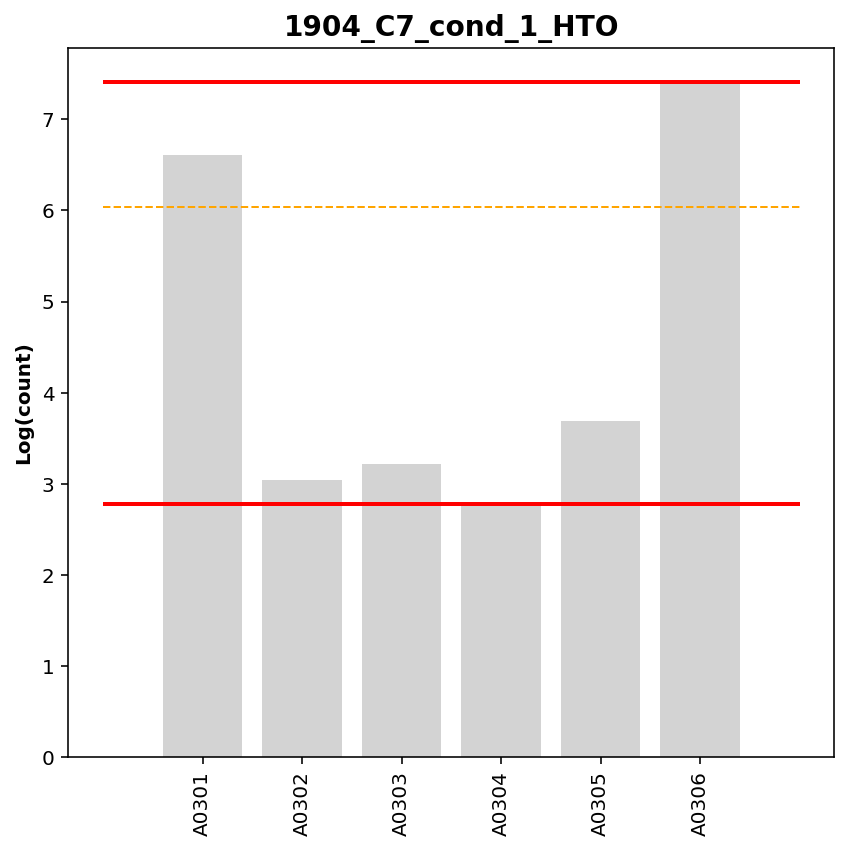

In [20]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.bar(df_dist.index, np.log(list(df_dist.values)), color="lightgray")
    
ax.set_ylabel("Log(count)", fontweight="bold")
ax.set_title(sample_name, fontsize=14, fontweight="heavy")
ax.tick_params(axis="x", rotation=90)
    
if len(df_dist) != 0:
    num_hashtags = len(df_dist.values)
    ax.hlines(y=np.log(max(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)
    ax.hlines(y=np.log(min(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)    
    ax.hlines(y=np.log(np.mean(list(df_dist.values))), xmin=-1, xmax=num_hashtags, colors='orange', linestyles='--', lw=1)    

plt.tight_layout()

plt.show()

## Reads Count

In [21]:
import numpy as np
import scipy.io

In [22]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "reads/matrix.mtx.gz")
)

In [23]:
barcodes = pd.read_csv(
    os.path.join(path_data, "reads/barcodes.tsv.gz"),
    sep="\t", 
    compression="gzip",
    header=None
)

In [24]:
features = pd.read_csv(
    os.path.join(path_data, "reads/features.tsv.gz"),
    sep="\t",
    compression="gzip",
    header=None
)

In [25]:
df_reads = pd.DataFrame(
    mtx.T.todense(),
    index=barcodes[0],
    columns=features[0]
)

In [26]:
df_reads

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped
0,,,,,,,
AATTCCTCATAGAATG,12809,2,3,2,0,20,241
AACCTTTTCGTAGGGA,12,24,0,1,0,17637,470
TACACCCGTTTCGCTC,18114,0,5,0,0,16,294
ACACTGACACCAGTTA,1,0,0,0,0,0,10
AAAGTCCGTGCCTGAC,19084,0,1,0,3,61,341
...,...,...,...,...,...,...,...
GCGAGAATCACCATGA,16,89,0,0,0,19185,365
CTAGGTACAAGGCGTA,20,26,0,10,2,15645,339
CTGCGAGTCTGAATCG,15,17,0,0,0,8599,200


### Matrix vs. Run Report

In [27]:
df_reads.sum().sum(), run_report["Reads processed"]

(43500914, 56902257)

In [28]:
df_reads.sum().sum() / run_report["Reads processed"] * 100

76.44848604159937

### Total Reads per Hashtag

In [29]:
df_reads.sum()

0
A0301-ACCCACCAGTAAGAC    13815454
A0302-GGTCGAGAGCATTCA      679743
A0303-CTTGCCGCATGTCAT      542529
A0304-AAAGCATTCTTCACG      568818
A0305-CTTTGTCTTTGTGAG      256863
A0306-TATGCTGCCACGGTA    26725669
unmapped                   911838
dtype: int64

### Total Reads per Celluar Barcode

In [30]:
df_reads.sum(axis=1)

0
AATTCCTCATAGAATG    13077
AACCTTTTCGTAGGGA    18144
TACACCCGTTTCGCTC    18429
ACACTGACACCAGTTA       11
AAAGTCCGTGCCTGAC    19490
                    ...  
GCGAGAATCACCATGA    19655
CTAGGTACAAGGCGTA    16042
CTGCGAGTCTGAATCG     8831
AGGCCACGTAATGCTC    14455
TCGTGGGAGGCGAAGG     7765
Length: 2572, dtype: int64

### Total Reads (except unmapped)

In [31]:
df_reads.iloc[:,:-1].sum().sum()

42589076

### Zero Rows

In [32]:
len(df_reads.sum(axis=1) == 0)

2572

In [33]:
len(df_reads[ df_reads.sum(axis=1) == 0 ]) / len(df_reads)

0.005443234836702955

### First Hashtag

In [34]:
# remove "Doublet" and pick the first hashtag
hashtags = list(set(df_class.hashID.unique()) - set(["Doublet"]))
first_hashtag = hashtags[0] if len(hashtags) > 0 else None
first_hashtag

'A0302'

In [35]:
df_reads.loc[ df_class[ df_class.hashID == first_hashtag ].index ].sort_values(by=df_reads.columns[0], ascending=False)

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped
TCATGGATCTGGGCGT,177,42776,0,1,1,50,749
ATTTCTGCACCAAATC,141,38472,0,0,0,31,715
CCCTTAGTCGCAAGAG,126,38060,5,0,0,60,680
TATTGGGGTCGACTGC,114,23387,0,8,0,16,388
CTGTACCCATTCACCC,111,33042,0,0,0,34,618
ACCGTTCAGATACTGA,109,27436,0,1,0,19,517
TTACAGGAGGTTCACT,107,35783,2,4,0,64,614
ACTCTCGGTCGTCTCT,107,33711,0,4,11,32,526
CATACAGCAGTATACC,103,32520,0,5,1,47,662
GCTGCAGTCCCGAATA,98,23451,0,0,6,20,423


### Overall Stats

In [36]:
df_reads.sum(axis=1).sort_values(ascending=False).describe()

count     2572.000000
mean     16913.263608
std       7221.985785
min          0.000000
25%      13527.000000
50%      16154.000000
75%      19469.750000
max      55178.000000
dtype: float64

### 95 Percentile

In [37]:
percentile_95 = df_reads.sum(axis=1).describe(percentiles=[0.95])["95%"]
percentile_95

31206.499999999985

In [38]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped
0,,,,,,,
TCTACATCAACTACGT,19621,77,11,0,0,16877,725
ATAGGCTGTCTCCTGT,5,80,0,2,2,30689,765
GACCAATTCCATCACC,37441,0,11,1,0,36,603
GAACTGTGTTCTTGCC,34,62,1,0,0,30516,734
TATATCCGTCATCTAG,32648,2,0,0,2,38,524
...,...,...,...,...,...,...,...
TAGGAGGCACATAGCT,39839,0,8,0,0,40,760
TCGGTCTAGGAGAGGC,15,69,0,0,0,30649,797
AACGGGACATAGATCC,31819,0,10,0,0,38,523


In [39]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ].sample(5, random_state=0)

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped
0,,,,,,,
CCTTCAGCATCGCTGG,586,63,0,1,10,39086,949
CCCAACTCAATACCTG,27,78,0,0,1,42624,973
TGGAGGAAGGCGTTAG,5,93,1,0,0,30497,660
TTACAGGAGGTTCACT,107,35783,2,4,0,64,614
GTATTTCAGACCAACG,93,33791,0,5,0,32,703


In [40]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ].sample(5, random_state=0).sum(axis=1)

0
CCTTCAGCATCGCTGG    40695
CCCAACTCAATACCTG    43703
TGGAGGAAGGCGTTAG    31256
TTACAGGAGGTTCACT    36574
GTATTTCAGACCAACG    34624
dtype: int64

### Histogram (sum of reads across hashtags)

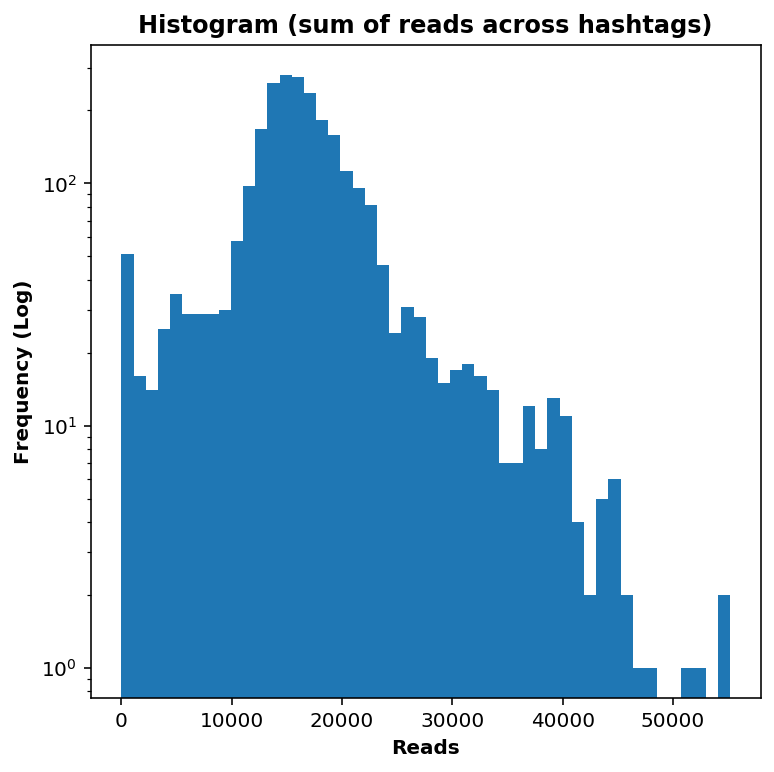

In [41]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.hist(df_reads.sum(axis=1).sort_values(ascending=False), bins=50)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.set_title("Histogram (sum of reads across hashtags)", fontweight="bold")

plt.yscale("log")
plt.show()

### Histogram (sum of reads per hashtag)

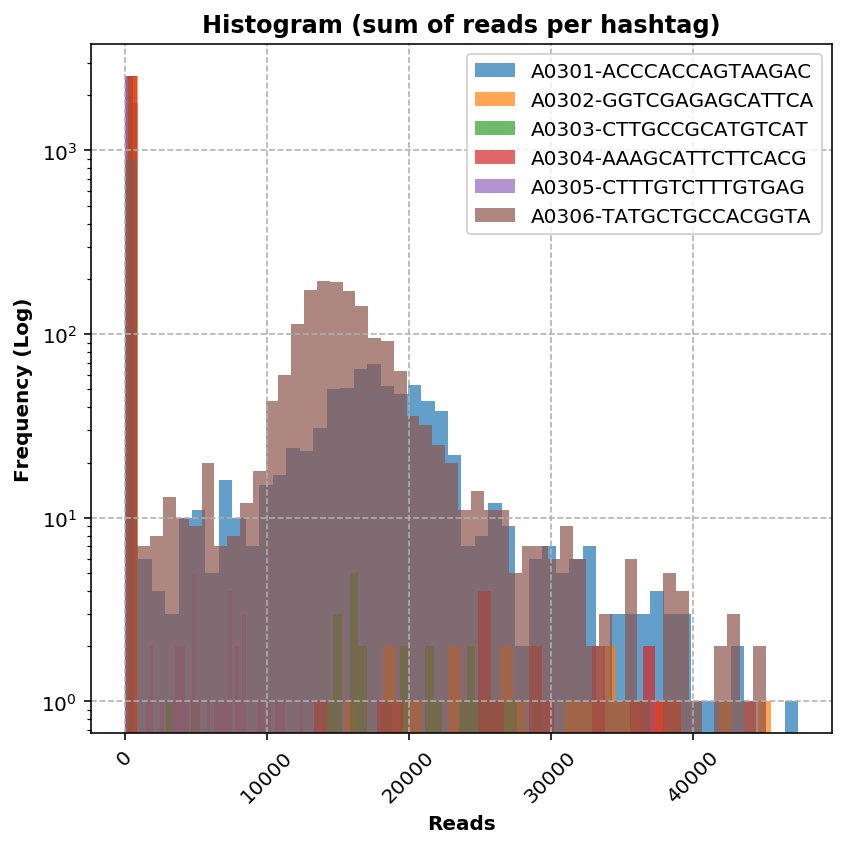

In [42]:
fig = plt.figure(figsize=(6, 6), facecolor="white")

ax = fig.add_subplot(111)
    
for idx, col in enumerate(df_reads.columns[:-1]):
    
    df_tmp = df_reads.iloc[:,idx].sort_values(ascending=False)

    ax.hist(df_tmp, bins=50, alpha=0.7, label=col)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.set_title("Histogram (sum of reads per hashtag)", fontweight="bold")
ax.grid(b=True, linestyle="--")
ax.legend()

plt.yscale("log")
plt.tight_layout()
plt.show()

### Unmapped

In [43]:
df_reads.sort_values(by="unmapped", ascending=False).iloc[:,-1]

0
CGGAATTAGGAACGAA    1191
TTGAACGTCAGCCTCT    1101
GATGATCCACTTCAAG    1055
GGCAGTCTCTTCGGTC    1044
GAGTTACCAGCAGGAT    1022
                    ... 
GTCATTTTCTGCGACA       0
ATGCGATCATGAAGTA       0
TTTATGCCATCCTTGC       0
CCTTCAGCAGGCACTC       0
ACGTACAGTCAGATTC       0
Name: unmapped, Length: 2572, dtype: int64

In [44]:
df_reads.unmapped.sum()

911838

## UMI Count

In [45]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "umis/matrix.mtx.gz")
)

In [46]:
barcodes = pd.read_csv(
    os.path.join(path_data, "umis/barcodes.tsv.gz"),
    sep="\t", 
    compression="gzip",
    header=None
)

In [47]:
features = pd.read_csv(
    os.path.join(path_data, "umis/features.tsv.gz"),
    sep="\t",
    compression="gzip",
    header=None
)

In [48]:
df_umis = pd.DataFrame(
    mtx.T.todense(),
    index=barcodes[0],
    columns=features[0]
)

In [49]:
df_umis

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped
0,,,,,,,
AATTCCTCATAGAATG,4506,1,2,1,0,8,94
AACCTTTTCGTAGGGA,8,7,0,1,0,6255,182
TACACCCGTTTCGCTC,6297,0,1,0,0,8,107
ACACTGACACCAGTTA,1,0,0,0,0,0,4
AAAGTCCGTGCCTGAC,6539,0,1,0,1,25,131
...,...,...,...,...,...,...,...
GCGAGAATCACCATGA,7,17,0,0,0,6611,151
CTAGGTACAAGGCGTA,11,8,0,4,1,5513,122
CTGCGAGTCTGAATCG,7,5,0,0,0,3022,72


### Histogram

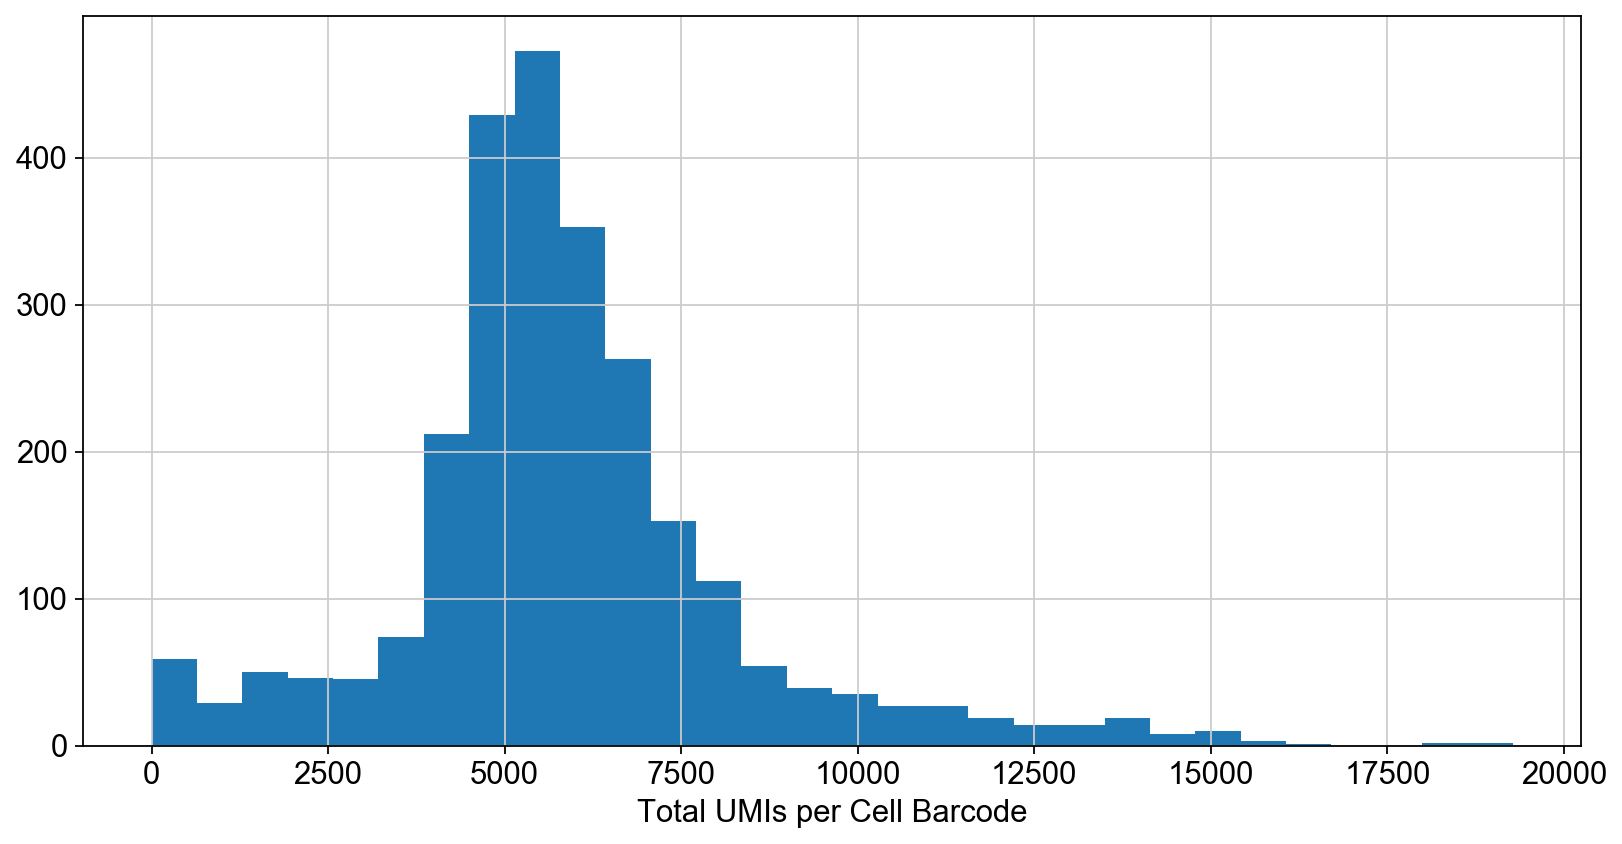

In [111]:
fig, ax = plt.subplots(figsize=(12,6), facecolor="white")

ax.hist(df_umis.values.sum(axis=1), bins=30)
ax.set_xlabel("Total UMIs per Cell Barcode")

plt.show()

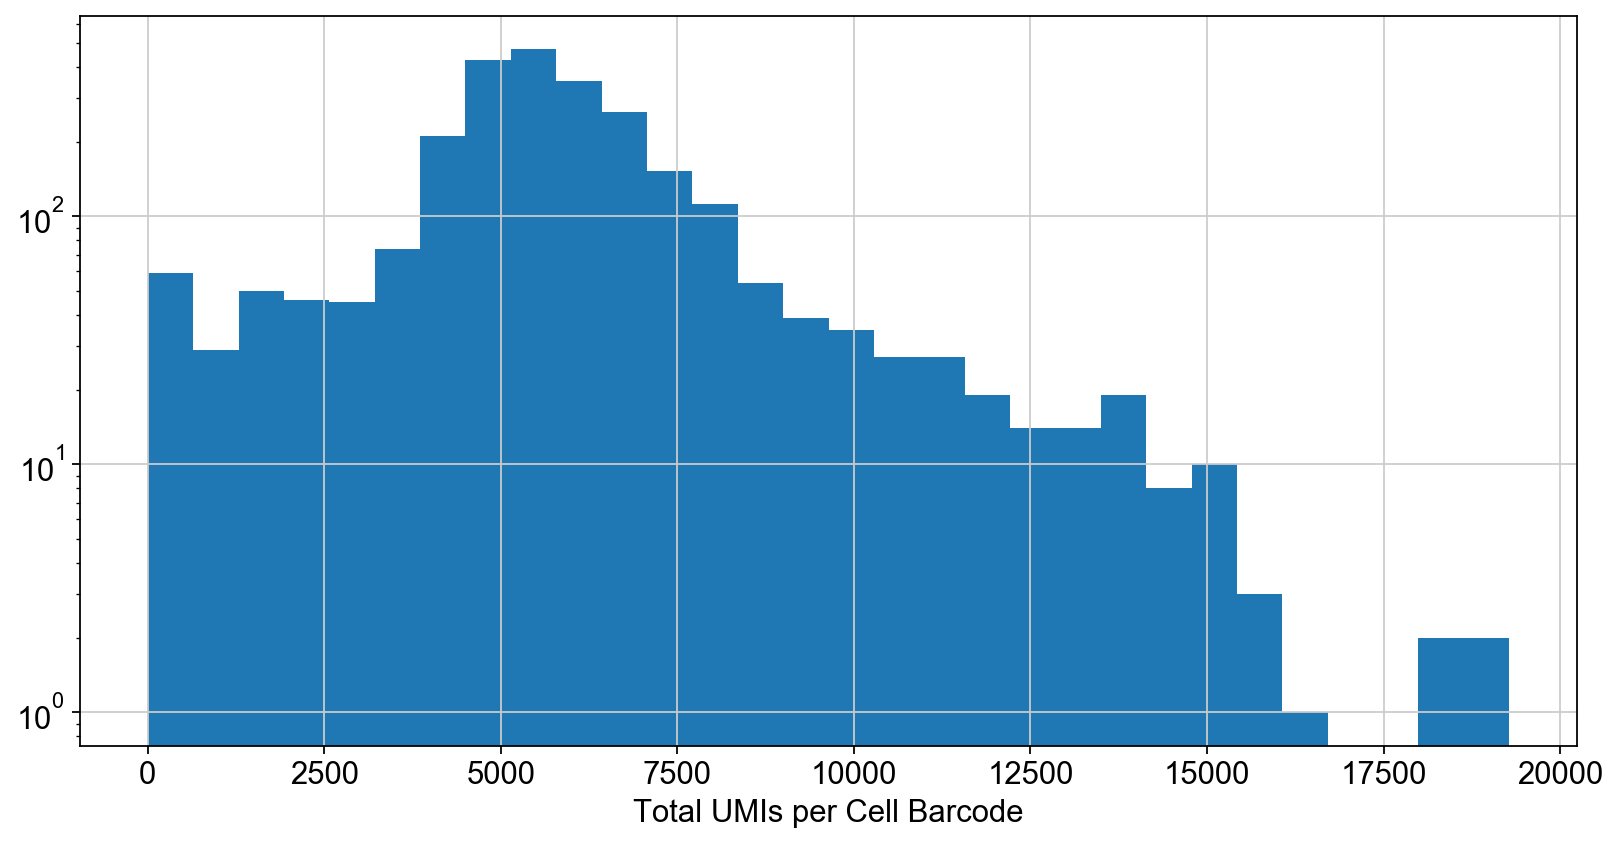

In [110]:
fig, ax = plt.subplots(figsize=(12,6), facecolor="white")

ax.hist(df_umis.values.sum(axis=1), bins=30)
ax.set_xlabel("Total UMIs per Cell Barcode")

plt.yscale("log")
plt.show()

## Reads per UMI

### Calculate

In [50]:
# reads divided by UMI, replace NaN with zero
df_reads_per_umi = (df_reads / df_umis).replace(to_replace=np.NaN, value=0)
# remove the "unmapped" column
df_reads_per_umi = df_reads_per_umi.iloc[:,0:-1]
df_reads_per_umi

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA
0,,,,,,
AATTCCTCATAGAATG,2.842654,2.000000,1.5,2.0,0.0,2.500000
AACCTTTTCGTAGGGA,1.500000,3.428571,0.0,1.0,0.0,2.819664
TACACCCGTTTCGCTC,2.876608,0.000000,5.0,0.0,0.0,2.000000
ACACTGACACCAGTTA,1.000000,0.000000,0.0,0.0,0.0,0.000000
AAAGTCCGTGCCTGAC,2.918489,0.000000,1.0,0.0,3.0,2.440000
...,...,...,...,...,...,...
GCGAGAATCACCATGA,2.285714,5.235294,0.0,0.0,0.0,2.901982
CTAGGTACAAGGCGTA,1.818182,3.250000,0.0,2.5,2.0,2.837838
CTGCGAGTCTGAATCG,2.142857,3.400000,0.0,0.0,0.0,2.845467


In [51]:
sum_umis = df_umis.sum(axis=1).sum()
sum_reads = df_reads.sum(axis=1).sum()

In [52]:
reads_per_umi = sum_reads / sum_umis
reads_per_umi

2.8754077622612577

### Histogram

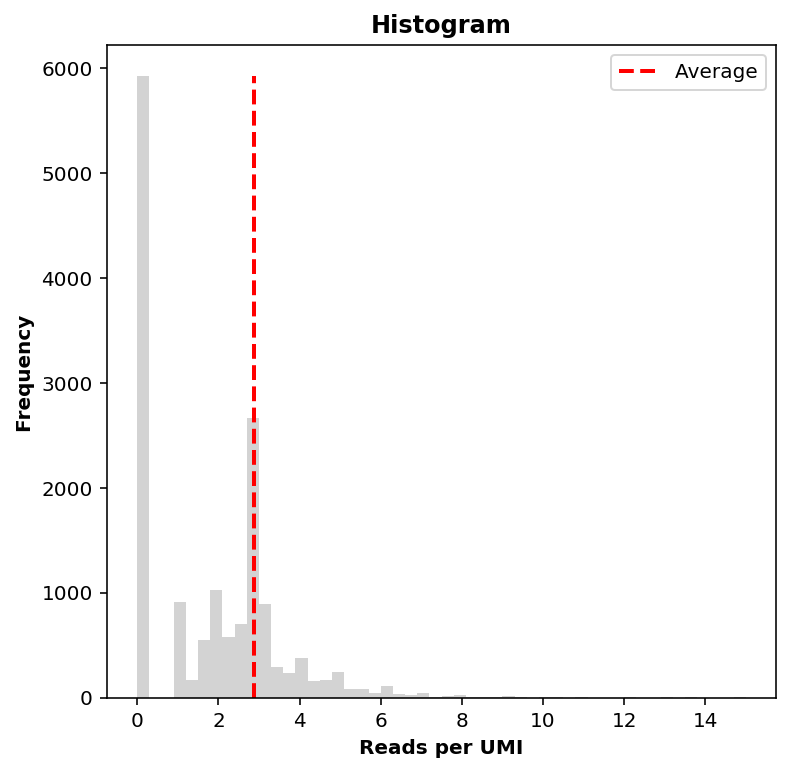

In [53]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

n, bins, _ = ax.hist(np.ravel(df_reads_per_umi.values), bins=50, color="lightgray")
ax.vlines(x=reads_per_umi, ymin=0, ymax=np.max(n), color="red", linestyle="--", lw=2, label="Average")

ax.set_xlabel("Reads per UMI", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_title("Histogram", fontweight="bold")
ax.legend()

plt.show()

## Merge (UMI + Class)

In [54]:
df_umi_class = pd.merge(
    df_umis, df_class,
    left_index=True, right_index=True,
    how="inner"
)

In [55]:
df_umi_class

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID
AATTCCTCATAGAATG,4506,1,2,1,0,8,94,A0301
AACCTTTTCGTAGGGA,8,7,0,1,0,6255,182,A0306
TACACCCGTTTCGCTC,6297,0,1,0,0,8,107,A0301
ACACTGACACCAGTTA,1,0,0,0,0,0,4,A0301
AAAGTCCGTGCCTGAC,6539,0,1,0,1,25,131,A0301
...,...,...,...,...,...,...,...,...
GCGAGAATCACCATGA,7,17,0,0,0,6611,151,A0306
CTAGGTACAAGGCGTA,11,8,0,4,1,5513,122,A0306
CTGCGAGTCTGAATCG,7,5,0,0,0,3022,72,A0306
AGGCCACGTAATGCTC,3,15,0,1,1,4664,111,A0306


## UMI (one vs. rest)

- Ideally, the winning one shouldn't be winning by having less than e.g. 10 UMIs?
- Ideally, the losing ones should have UMIs close to zero.

### All

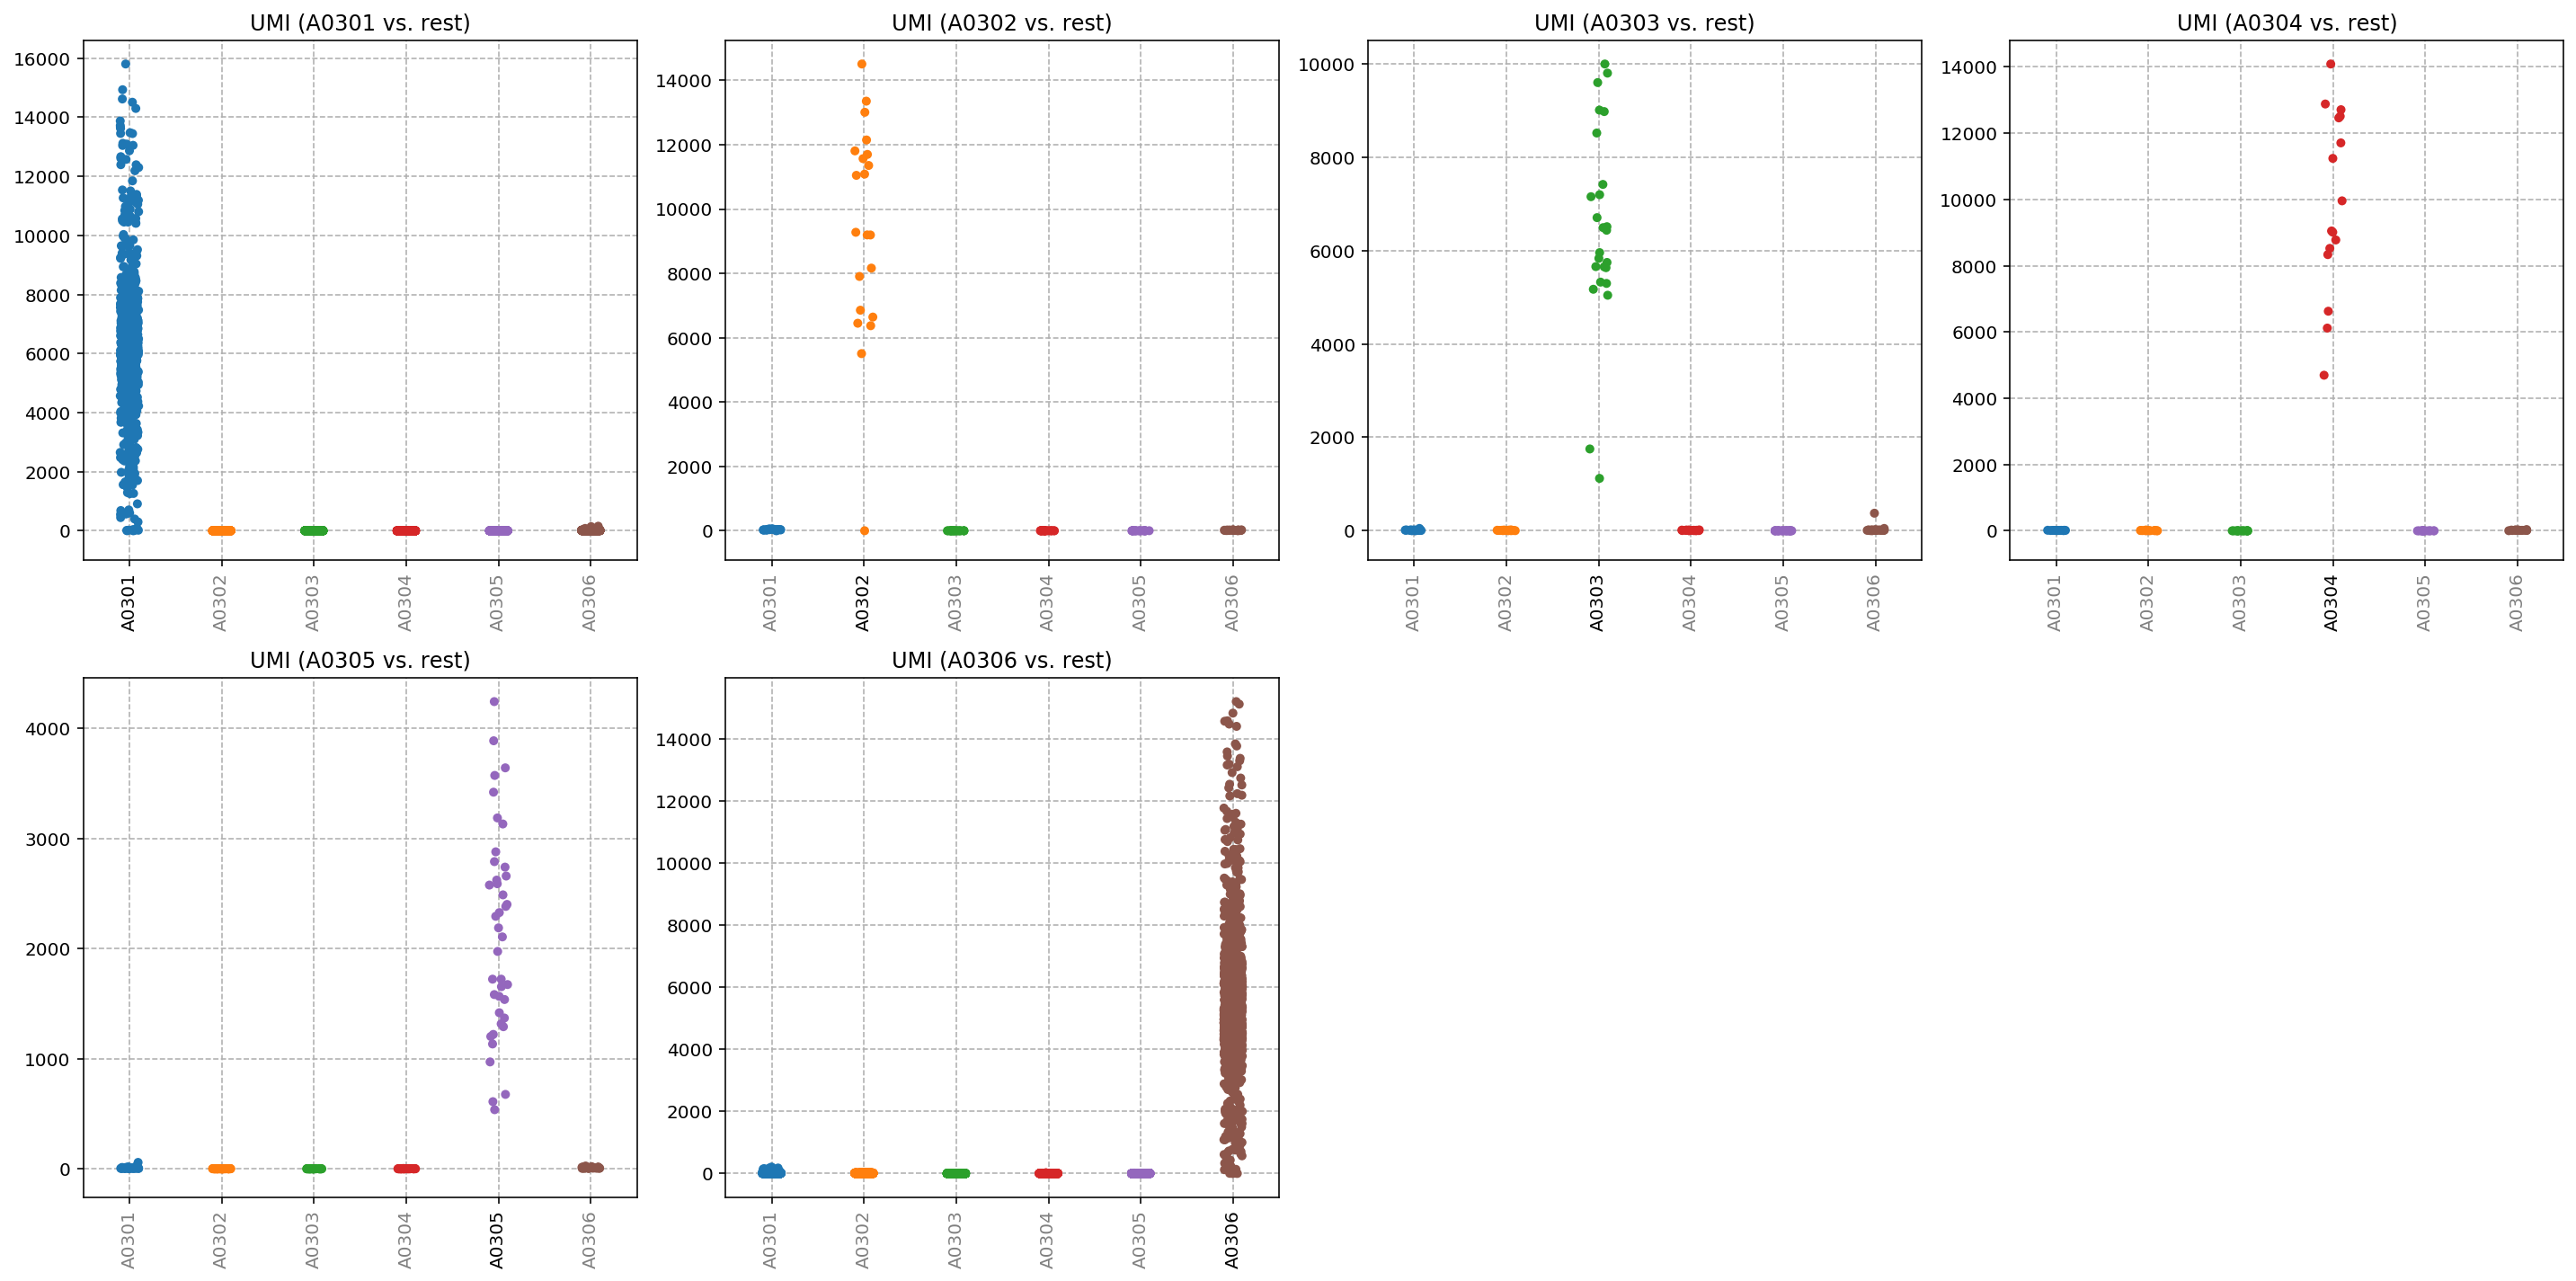

In [56]:
num_hashtags = len(df_umi_class.columns[:-2])
num_cols = 4
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for hashtag in sorted(hashtags):
    
    idx_plot += 1
    
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)

    df_tmp = df_umi_class[ df_umi_class.hashID == hashtag ].iloc[:,0:-2]
    df_tmp.columns = list(map(lambda col: col.split("-")[0], df_tmp.columns))

    sns.stripplot(data=df_tmp, ax=ax)

    ax.set_title(f"UMI ({hashtag} vs. rest)")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(b=True, linestyle="--")
#     ax.set_yscale("log")
    
    for tick in ax.xaxis.get_major_ticks():
        if tick.label.get_text() == hashtag:
            tick.label.set_color("black")
        else:
            tick.label.set_color("gray")

plt.tight_layout()
plt.show()

### 25th Percentile

In [57]:
umi_sum_percentile_25 = df_umi_class.iloc[:,0:-2].sum(axis=1).describe()["25%"]
umi_sum_percentile_25

4596.0

In [58]:
df_umi_class[ (df_umi_class.iloc[:,0:-2].sum(axis=1) < umi_sum_percentile_25) & (df_umi_class.hashID != "Doublet") ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID
AATTCCTCATAGAATG,4506,1,2,1,0,8,94,A0301
ACACTGACACCAGTTA,1,0,0,0,0,0,4,A0301
TTACCATTCCCGTAAA,4,2,0,0,0,1009,24,A0306
GGGACAAAGTAACGTA,22,10,1,1,0,4023,118,A0306
TGCGATACAAACTAAG,5,2,0,0,0,3865,85,A0306
...,...,...,...,...,...,...,...,...
AGTCACAGTGAGGAAA,8,7,0,1,0,4286,123,A0306
TTTCAGTGTAGCGTAG,9,2,0,0,0,3192,62,A0306
AGGATAATCTACTATC,4227,0,1,0,0,5,79,A0301
CTGCGAGTCTGAATCG,7,5,0,0,0,3022,72,A0306


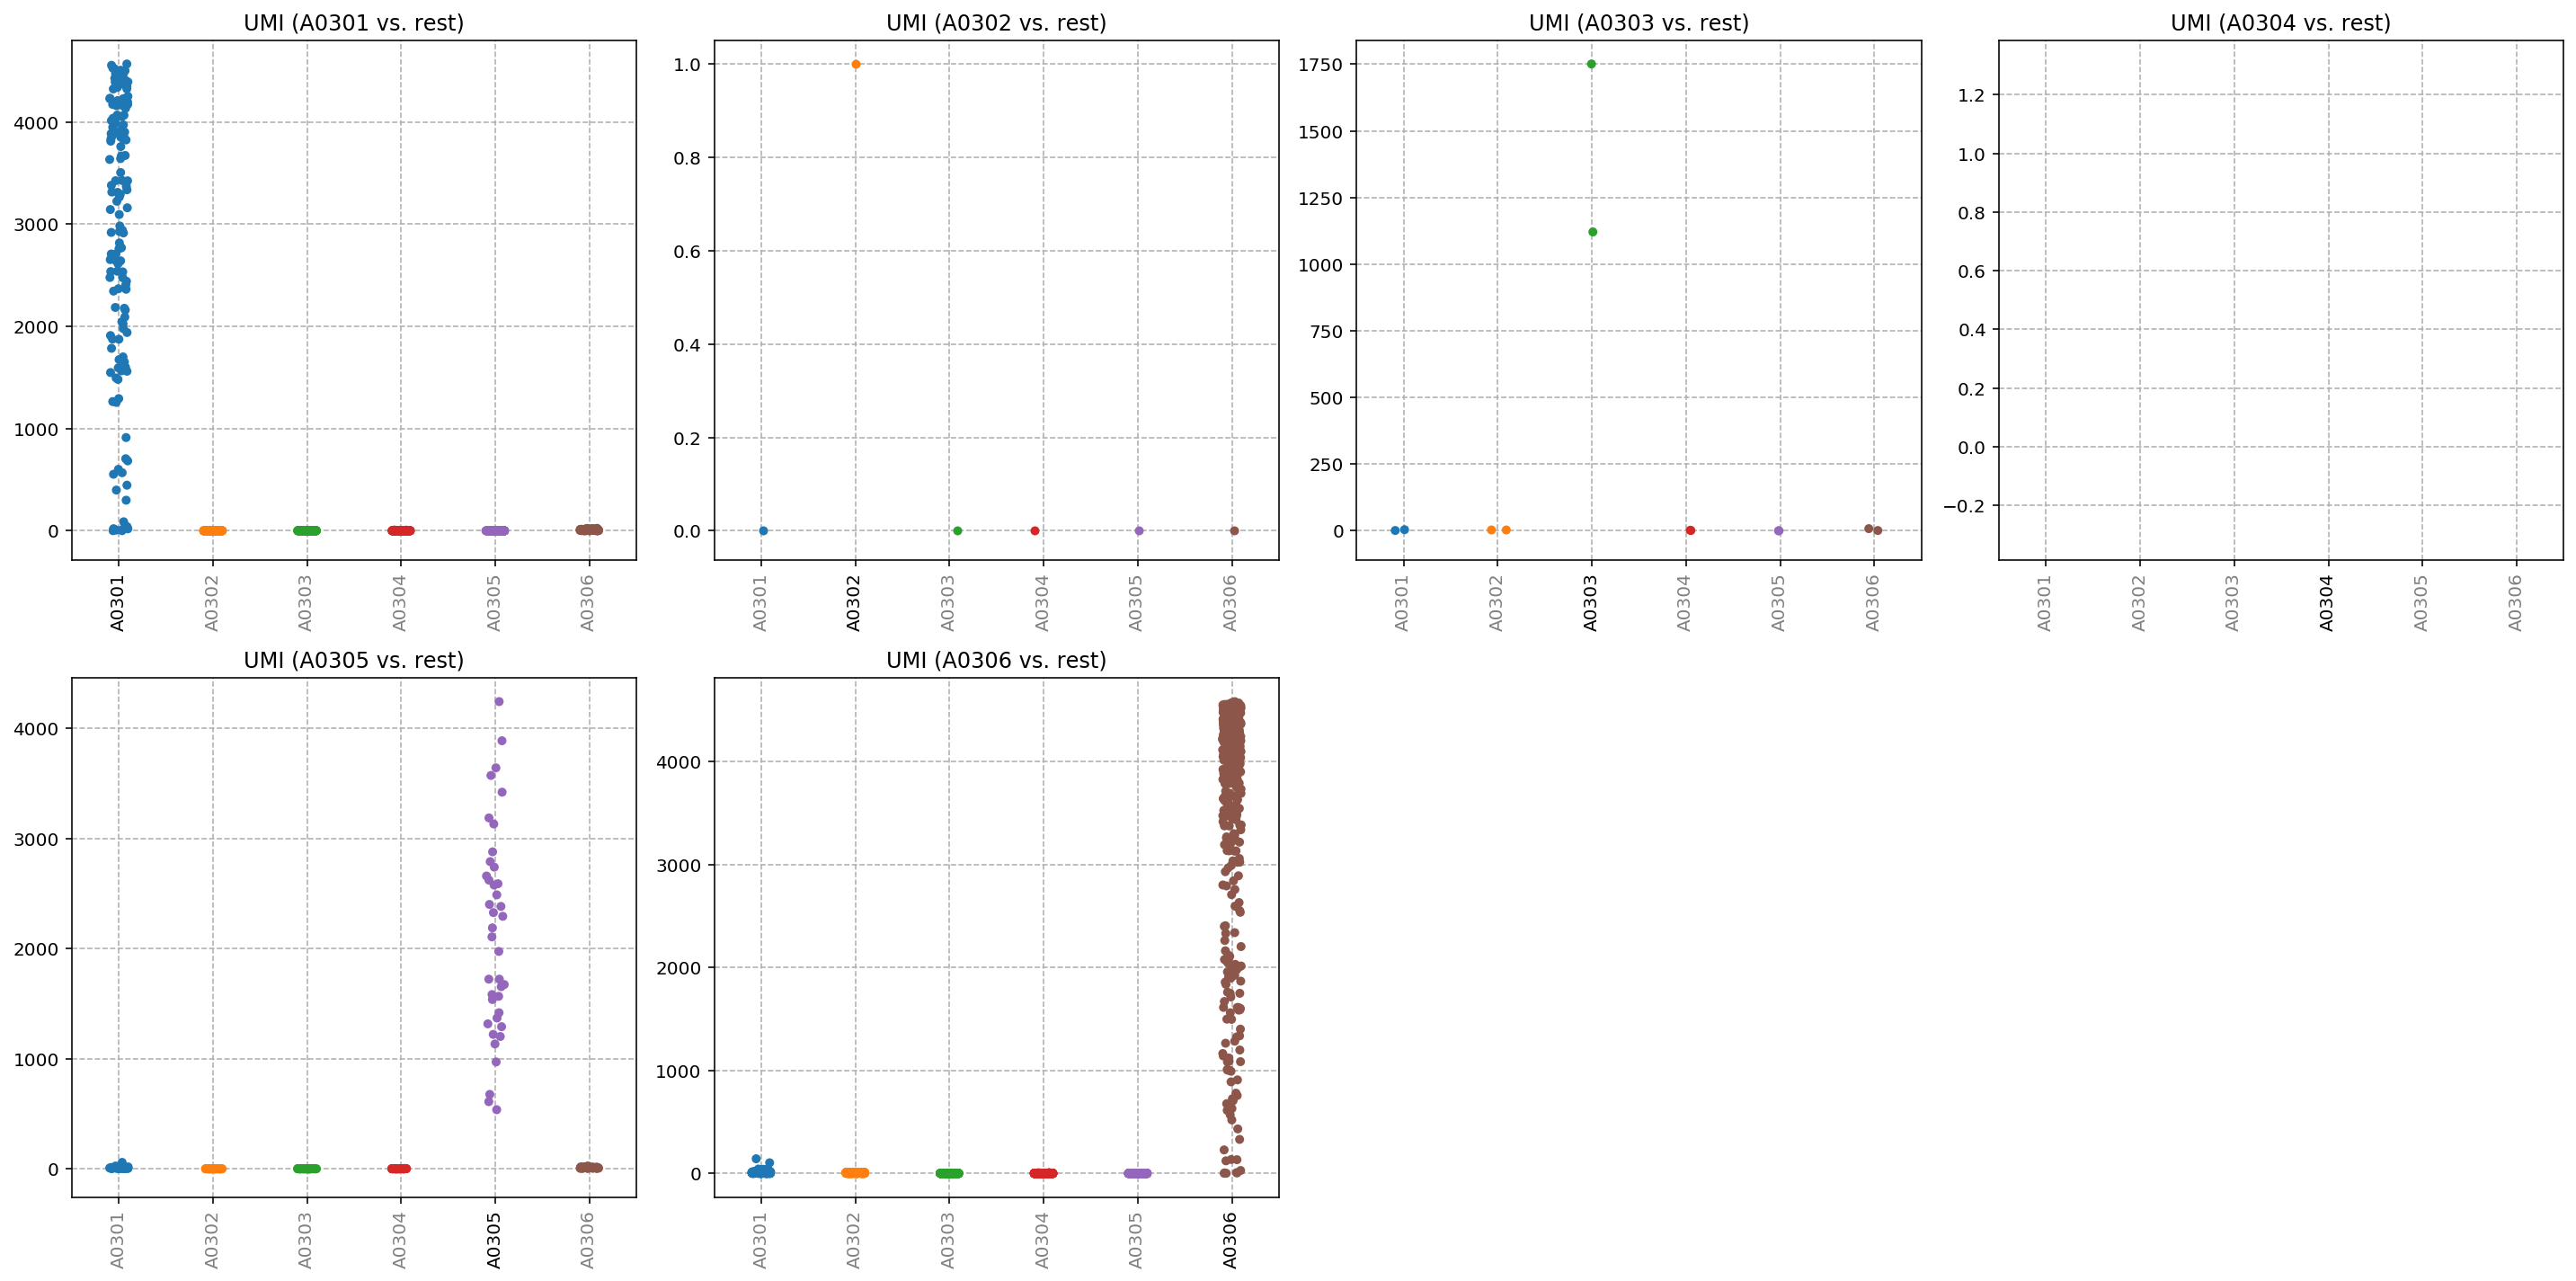

In [59]:
num_hashtags = len(df_umi_class.columns[:-2])
num_cols = 4
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for hashtag in sorted(hashtags):
    
    idx_plot += 1
    
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)

    df_tmp = df_umi_class[ (df_umi_class.iloc[:,0:-2].sum(axis=1) < umi_sum_percentile_25) & (df_umi_class.hashID == hashtag) ].iloc[:,0:-2]
    df_tmp.columns = list(map(lambda col: col.split("-")[0], df_tmp.columns))

    sns.stripplot(data=df_tmp, ax=ax)

    ax.set_title(f"UMI ({hashtag} vs. rest)")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(b=True, linestyle="--")
    
    for tick in ax.xaxis.get_major_ticks():
        if tick.label.get_text() == hashtag:
            tick.label.set_color("black")
        else:
            tick.label.set_color("gray")

plt.tight_layout()
plt.show()

## UMI Distribution

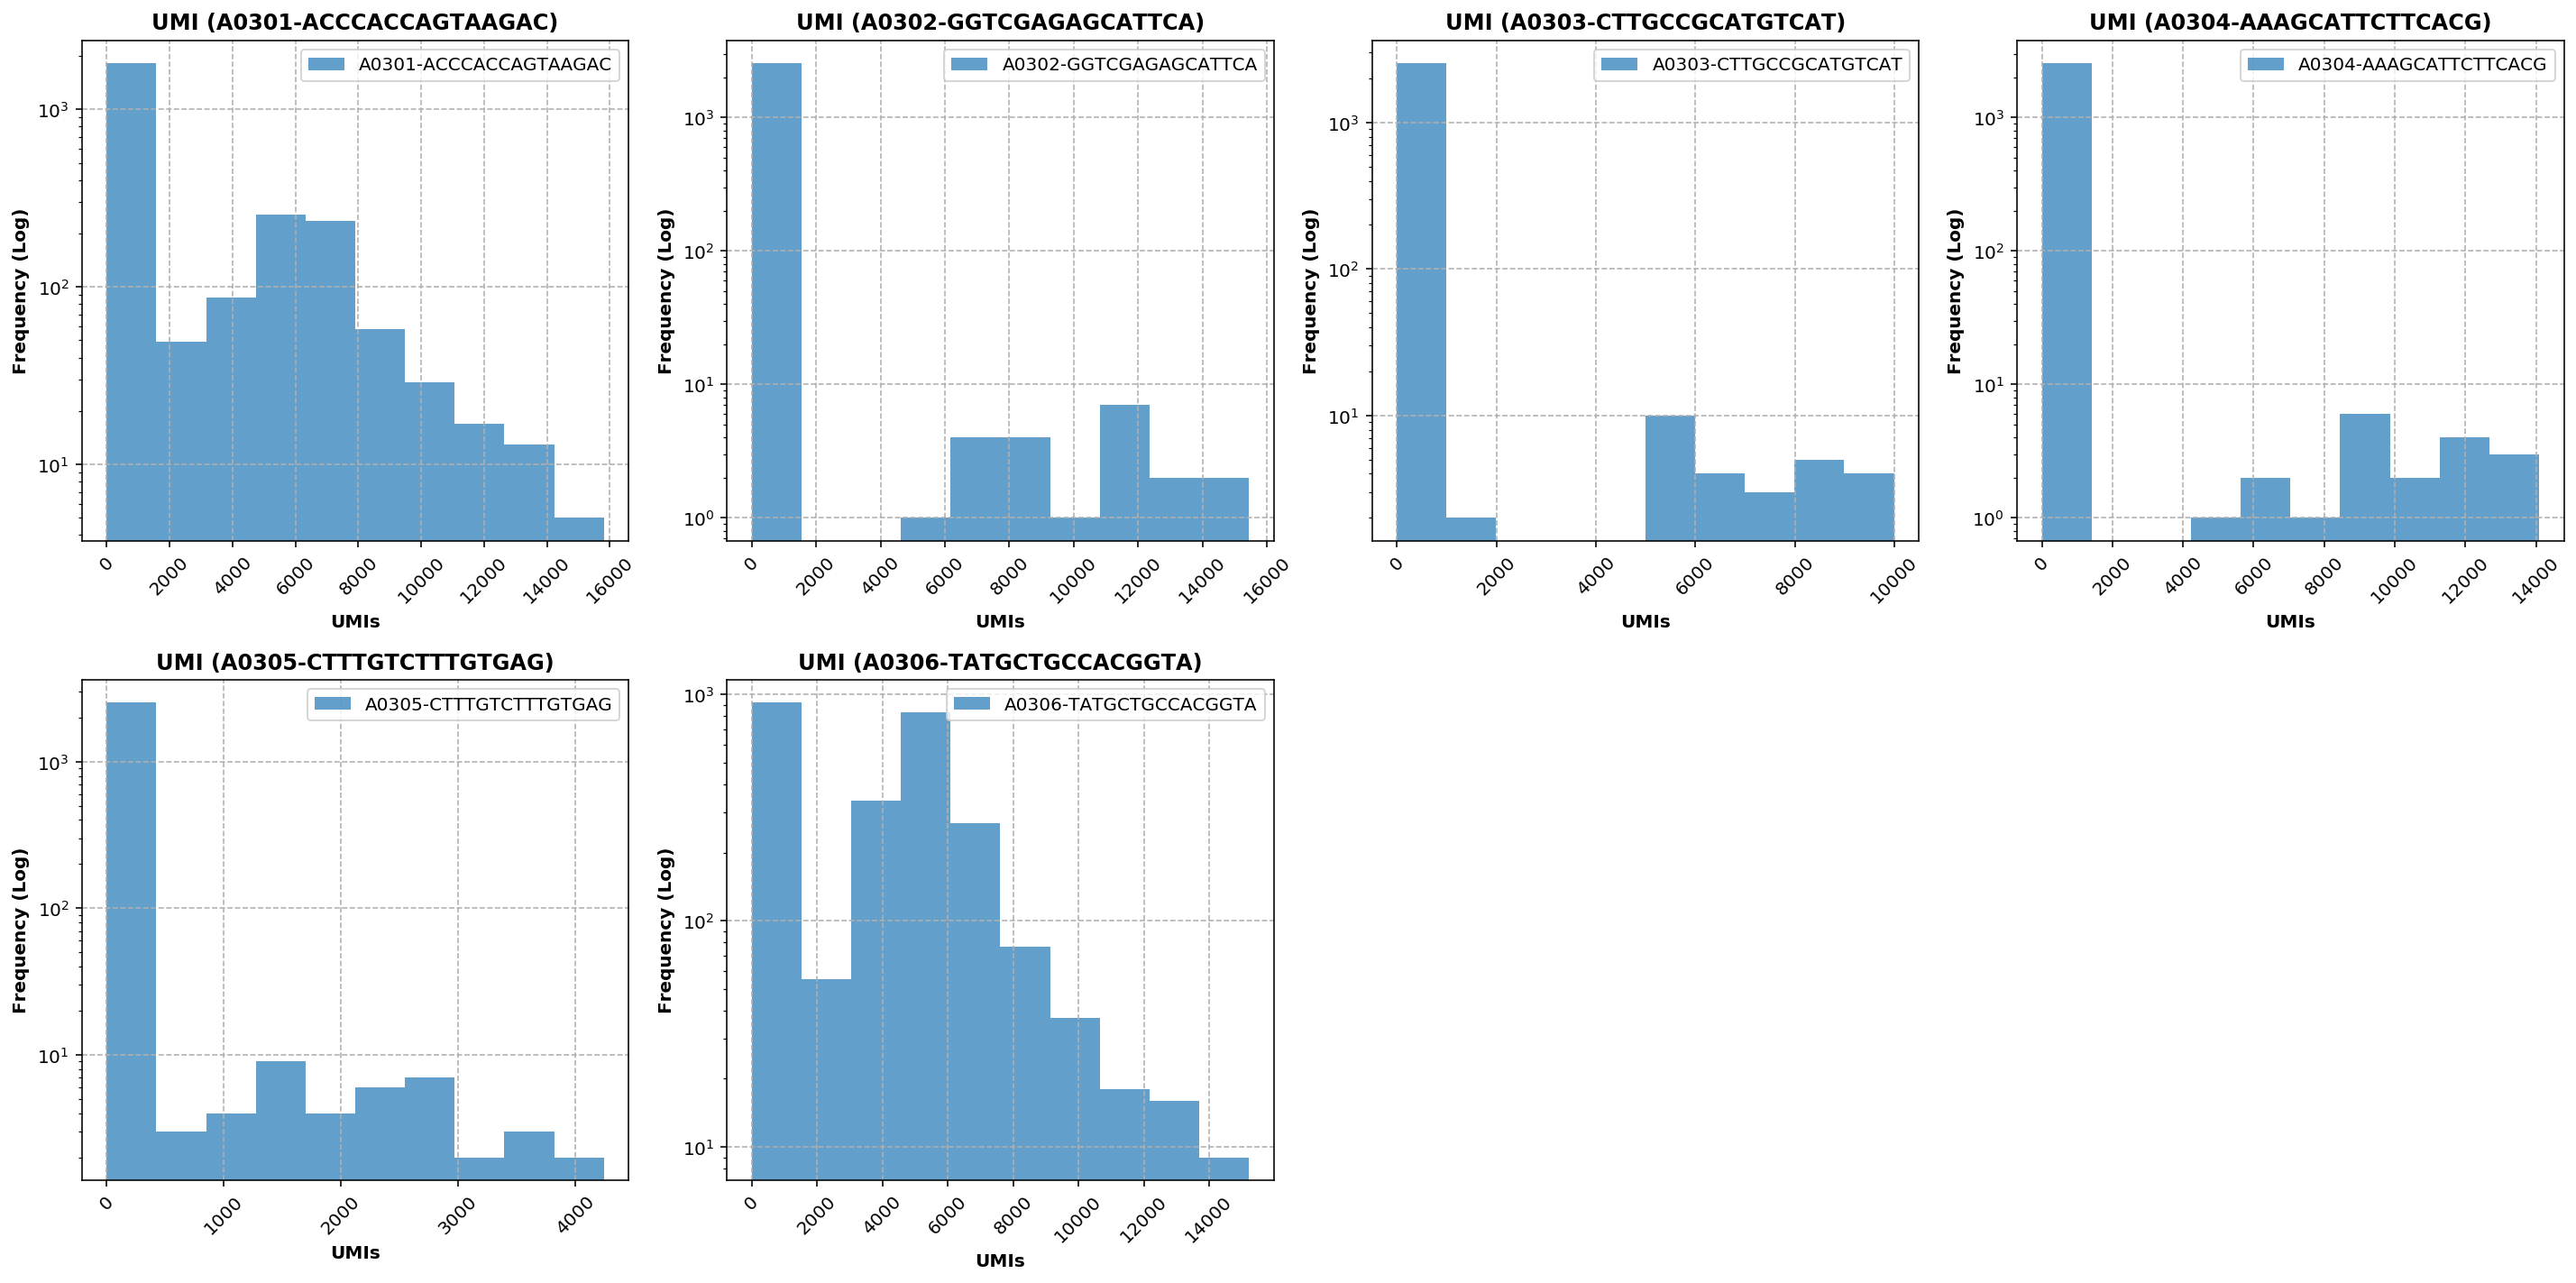

In [60]:
num_hashtags = len(df_umi_class.columns[:-2])
num_cols = 4
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for idx, col in enumerate(df_umi_class.columns[:-2]):

    idx_plot += 1
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)
    
    df_tmp = df_umi_class.iloc[:,idx].sort_values(ascending=False)

    ax.hist(df_tmp, bins=10, alpha=0.7, label=col)

    ax.set_xlabel("UMIs", fontweight="bold")
    ax.set_ylabel("Frequency (Log)", fontweight="bold")
    ax.tick_params(axis="x", rotation=45)
    ax.set_title(f"UMI ({col})", fontweight="bold")
    ax.grid(b=True, linestyle="--")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()
plt.show()

## Negative Check

In [61]:
df2 = df_umi_class.copy()

In [62]:
df2 = df2.assign(total=df2.iloc[:,:-2].sum(axis=1))
df2

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
AATTCCTCATAGAATG,4506,1,2,1,0,8,94,A0301,4518
AACCTTTTCGTAGGGA,8,7,0,1,0,6255,182,A0306,6271
TACACCCGTTTCGCTC,6297,0,1,0,0,8,107,A0301,6306
ACACTGACACCAGTTA,1,0,0,0,0,0,4,A0301,1
AAAGTCCGTGCCTGAC,6539,0,1,0,1,25,131,A0301,6566
...,...,...,...,...,...,...,...,...,...
GCGAGAATCACCATGA,7,17,0,0,0,6611,151,A0306,6635
CTAGGTACAAGGCGTA,11,8,0,4,1,5513,122,A0306,5537
CTGCGAGTCTGAATCG,7,5,0,0,0,3022,72,A0306,3034
AGGCCACGTAATGCTC,3,15,0,1,1,4664,111,A0306,4684


In [63]:
df2.sort_values(by="total", ascending=False, inplace=True)

### Zero Rows

In [64]:
df2.loc[ df2.total == 0 ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
CATCCACCACCTCGTT,0,0,0,0,0,0,0,Doublet,0
ATAGACCTCGGTGTTA,0,0,0,0,0,0,0,Doublet,0
CCGGTAGTCACGACTA,0,0,0,0,0,0,0,Doublet,0
TGGGCGTGTGAGTGAC,0,0,0,0,0,0,1,Doublet,0
GGGAGATCAGTTTACG,0,0,0,0,0,0,1,Doublet,0
CGAGGAAGTGGACCTC,0,0,0,0,0,0,1,Doublet,0
TGTTCCGGTAAGTGTA,0,0,0,0,0,0,0,Doublet,0
TCACAAGTCAACTCTT,0,0,0,0,0,0,0,Doublet,0
GTCGTAATCTGGCCTC,0,0,0,0,0,0,0,Doublet,0
ATTCTACGTGAGCGAT,0,0,0,0,0,0,0,Doublet,0


In [65]:
df2.loc[ df2.total == 0 ].shape

(20, 9)

In [66]:
len(df2.loc[ df2.total == 0 ]) / len(df2) * 100.0

0.7776049766718507

### Singlets

In [67]:
df2[ df2.hashID != "Doublet" ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
ATCCATTGTCGAACAG,15805,0,6,1,1,19,303,A0301,15832
TGGGCTGAGTCGCCAC,12,28,0,0,0,15218,397,A0306,15258
TTCTAACGTGCTCTCT,15,8,0,1,0,15136,365,A0306,15160
GCTGCAGCACTGTGAT,14934,3,4,2,0,18,270,A0301,14961
GGGTATTTCTTTCCAA,14,22,1,0,0,14846,385,A0306,14883
...,...,...,...,...,...,...,...,...,...
ACACTGACACCAGTTA,1,0,0,0,0,0,4,A0301,1
GTCATTTTCTGCGACA,1,0,0,0,0,0,0,A0301,1
GGGAGATAGTGATCGG,0,0,0,0,0,1,1,A0306,1
CGGACACAGGGCATGT,0,1,0,0,0,0,1,A0302,1


In [68]:
df2[ (df2.hashID != "Doublet") & (df2.total < 10) ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
CCTATCGCATCCGTTC,7,0,0,0,0,2,2,A0301,9
GTATTGGAGGTTCTGC,1,0,0,0,0,7,0,A0306,8
ATCATTCTCTAACCGG,0,0,0,0,0,5,0,A0306,5
TCGTAGACAAAGCGGT,0,0,0,0,0,5,0,A0306,5
ACACTGACACCAGTTA,1,0,0,0,0,0,4,A0301,1
GTCATTTTCTGCGACA,1,0,0,0,0,0,0,A0301,1
GGGAGATAGTGATCGG,0,0,0,0,0,1,1,A0306,1
CGGACACAGGGCATGT,0,1,0,0,0,0,1,A0302,1
TGGGAAGTCCGCTGTT,0,0,0,0,0,1,0,A0306,1


In [69]:
df2[ (df2.hashID != "Doublet") & (df2.total < 10) ].shape

(9, 9)

In [70]:
df2[ (df2.hashID != "Doublet") & (df2.total >= 10) ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
ATCCATTGTCGAACAG,15805,0,6,1,1,19,303,A0301,15832
TGGGCTGAGTCGCCAC,12,28,0,0,0,15218,397,A0306,15258
TTCTAACGTGCTCTCT,15,8,0,1,0,15136,365,A0306,15160
GCTGCAGCACTGTGAT,14934,3,4,2,0,18,270,A0301,14961
GGGTATTTCTTTCCAA,14,22,1,0,0,14846,385,A0306,14883
...,...,...,...,...,...,...,...,...,...
GCCAGGTAGATGGGCT,40,0,0,0,0,7,1,A0301,47
GCACTAAAGATTAGTG,3,0,0,0,0,28,1,A0306,31
ATGGGTTCAGCTCTCT,20,0,0,0,0,0,1,A0301,20
AGTCAACAGCAGTTCC,19,0,0,0,0,0,0,A0301,19


### Doublets

In [71]:
df2[ df2.hashID == "Doublet" ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
CGTGAATTCGGTAGAG,7370,12,3,11565,0,20,310,Doublet,18970
GACTCTCGTGCACAAG,2944,15437,2,1,0,157,444,Doublet,18541
TTCCTAAGTAGGCAGT,9366,11,8739,8,0,17,335,Doublet,18141
TTGAACGTCAGCCTCT,5350,24,1,1,0,12251,413,Doublet,17627
GTCCTCACACGGTCTG,5607,10,2,1,0,9938,367,Doublet,15558
...,...,...,...,...,...,...,...,...,...
TTGCGTCGTAATTGGA,0,0,0,0,0,0,0,Doublet,0
ACGATGTCACGGCGTT,0,0,0,0,0,0,1,Doublet,0
TGTCCCAGTGGGTATG,0,0,0,0,0,0,0,Doublet,0
TAGACCAGTACGAAAT,0,0,0,0,0,0,0,Doublet,0


In [72]:
df2[ (df2.hashID == "Doublet") & (df2.total < 10) ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
CATCAAGAGAATTGTG,1,1,0,0,0,1,0,Doublet,3
TCTATCATCTCAGCGA,2,0,0,0,0,1,0,Doublet,3
CATCCACCACCTCGTT,0,0,0,0,0,0,0,Doublet,0
ATAGACCTCGGTGTTA,0,0,0,0,0,0,0,Doublet,0
CCGGTAGTCACGACTA,0,0,0,0,0,0,0,Doublet,0
TGGGCGTGTGAGTGAC,0,0,0,0,0,0,1,Doublet,0
GGGAGATCAGTTTACG,0,0,0,0,0,0,1,Doublet,0
CGAGGAAGTGGACCTC,0,0,0,0,0,0,1,Doublet,0
TGTTCCGGTAAGTGTA,0,0,0,0,0,0,0,Doublet,0
TCACAAGTCAACTCTT,0,0,0,0,0,0,0,Doublet,0


In [73]:
df2[ (df2.hashID == "Doublet") & (df2.total >= 10) ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total
CGTGAATTCGGTAGAG,7370,12,3,11565,0,20,310,Doublet,18970
GACTCTCGTGCACAAG,2944,15437,2,1,0,157,444,Doublet,18541
TTCCTAAGTAGGCAGT,9366,11,8739,8,0,17,335,Doublet,18141
TTGAACGTCAGCCTCT,5350,24,1,1,0,12251,413,Doublet,17627
GTCCTCACACGGTCTG,5607,10,2,1,0,9938,367,Doublet,15558
GCCATTCAGTCATGAA,5664,13,1,1,0,9350,350,Doublet,15029
TTGTTGTCACTGCATA,7733,10,4,0,0,6779,299,Doublet,14526
TTCCGGTTCAACTACG,6242,11,3,1,0,7922,300,Doublet,14179
ATTCAGGTCACGGGCT,25,16,0,8729,0,5160,268,Doublet,13930
GATGCTACAAGCCTGC,7192,5,0,3,0,6443,263,Doublet,13643


## Max vs. Rest Sum

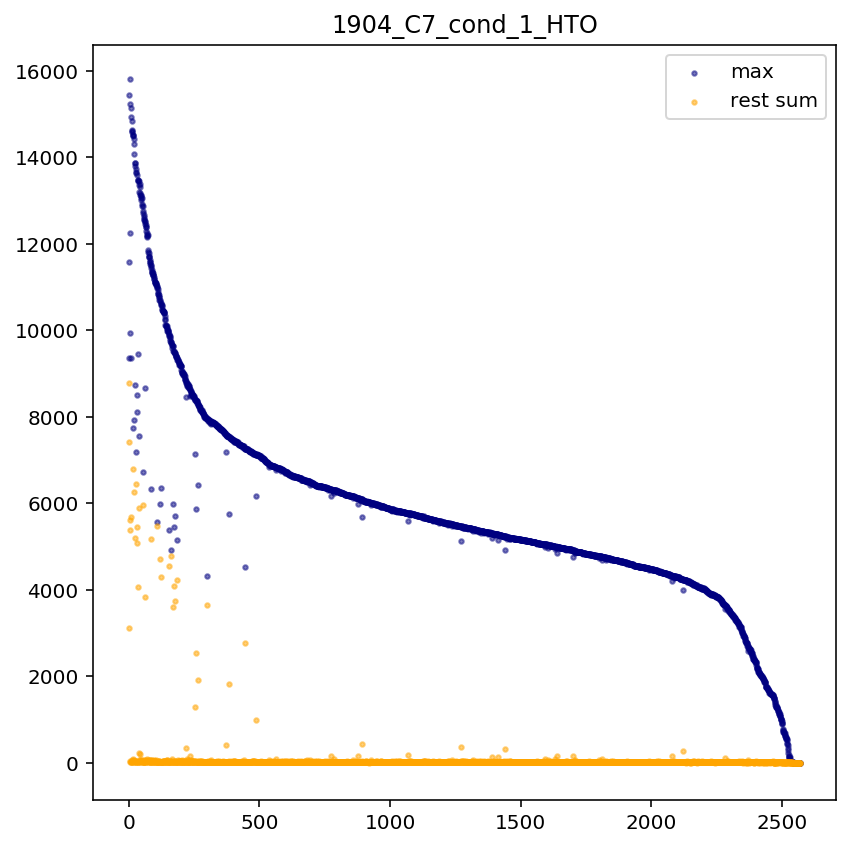

In [74]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

df_sorted = pd.DataFrame(
    np.vstack(df2.iloc[:,:-3].apply(lambda row: sorted(row, reverse=True), axis=1)),
    index=df_umi_class.index
)
dfx = df_sorted.copy()
dfx = dfx.assign(rest=df_sorted.iloc[:,1:].sum(axis=1))
dfx = dfx.assign(maxx=df_sorted.max(axis=1))

ax.scatter(range(len(dfx)), dfx.maxx, c="navy", s=5, alpha=0.5, label="max")
ax.scatter(range(len(dfx)), dfx.rest, c="orange", s=5, alpha=0.5, label="rest sum")
ax.legend()
ax.set_title(sample_name)

plt.tight_layout()
plt.show()    

## Classifiy Negatives Using Inflection Points

In [75]:
def find_inflection_points(umi_sum, window_size=10, window_size2=10):
    
    # skip the first ten points
    umi_sum = umi_sum[10:]
    
    if window_size > 0:
        ms2 = pd.Series(umi_sum).rolling(window_size).mean()
    else:
        ms2 = umi_sum

    d1 = np.diff(ms2)

    if window_size2 > 0:
        ms3 = pd.Series(d1).rolling(window_size2).mean()
        d2 = np.diff(ms3)
    else:
        d2 = np.diff(d1)

    # throw out an extra 5% of cells from where the inflection point is found.
    # these cells are empirically determined to have "transition" library sizes
    # that confound downstream analysis

    inflection_pts = np.where(d2 == 0)[0]

    if len(inflection_pts) == 0:
        # no points have 2nd derivate=0
        # remove nan, abs, and find the one that is most close to zero
        # sort in asending order and pick the first five
        print("plan B")
        inflection_pts = np.argsort(d2[~np.isnan(d2)])[:10]
        inflection_pts = np.sort(inflection_pts)

    return inflection_pts, d1, d2, ms2

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def fit_linear(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    
    return y_pred, model.coef_[0], model.intercept_

def fit_polynomial(x, y):
    polynomial_features= PolynomialFeatures(degree=3)
    X = polynomial_features.fit_transform(x.reshape(-1,1))    
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    return y_pred, model.coef_, model.intercept_

plan B


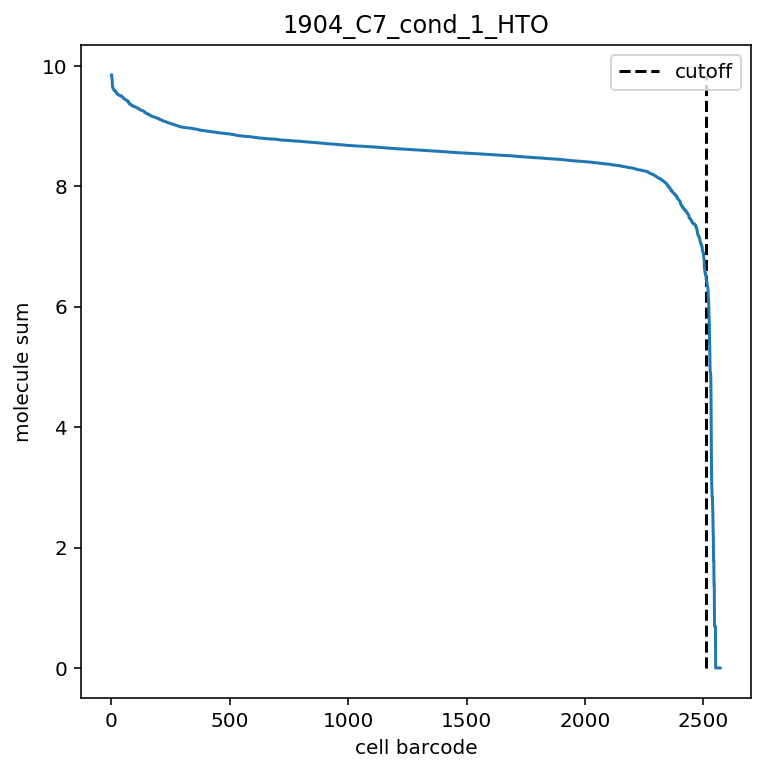

In [77]:
cutoffs = []

fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
  
x = np.array(range(0, len(df2)))
ms = np.log(df2.total + 1)
inflection_pts, d1, d2, ms2 = find_inflection_points(ms, 10, 10)
y_pred, _, intercept_poly = fit_polynomial(x, ms)    
mse_poly = metrics.mean_squared_error(ms, y_pred)
_, slope, intercept_linear = fit_linear(x, ms)

#     inflection_pt = inflection_pts[0]
#     inflection_pt = inflection_pts[-1]

if intercept_poly < 4:
    inflection_pt = inflection_pts[0]
elif intercept_poly < 5 and mse_poly >= 0.2:
    inflection_pt = inflection_pts[0]
else:
    if slope < -0.003:
        # fixme: we have no good inflection points     
        inflection_pt = int(len(df_umi_class) * 0.95)
    else:
        # 95% point
        inflection_pt = inflection_pts[int(len(inflection_pts)*0.99)]

cutoffs.append(inflection_pt)

ax.plot(range(0, len(df2)), np.log(df2.total + 1))
ax.set_ylabel("molecule sum")
ax.set_xlabel("cell barcode")
ax.vlines(x=inflection_pt, ymin=0, ymax=np.log(np.max(df2.total)), linestyle='--', label="cutoff")
ax.set_title(sample_name)
ax.legend()

plt.show()

In [78]:
inflection_pt

2511

In [79]:
inflection_pts

array([2498, 2499, 2500, 2502, 2503, 2504, 2505, 2506, 2507, 2511])

In [80]:
df3 = df2.copy()

In [81]:
df3 = df3.assign(hashID2=df3.hashID)

In [82]:
df3

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,total,hashID2
CGTGAATTCGGTAGAG,7370,12,3,11565,0,20,310,Doublet,18970,Doublet
GACTCTCGTGCACAAG,2944,15437,2,1,0,157,444,Doublet,18541,Doublet
TTCCTAAGTAGGCAGT,9366,11,8739,8,0,17,335,Doublet,18141,Doublet
TTGAACGTCAGCCTCT,5350,24,1,1,0,12251,413,Doublet,17627,Doublet
ATCCATTGTCGAACAG,15805,0,6,1,1,19,303,A0301,15832,A0301
...,...,...,...,...,...,...,...,...,...,...
TTGCGTCGTAATTGGA,0,0,0,0,0,0,0,Doublet,0,Doublet
ACGATGTCACGGCGTT,0,0,0,0,0,0,1,Doublet,0,Doublet
TGTCCCAGTGGGTATG,0,0,0,0,0,0,0,Doublet,0,Doublet
TAGACCAGTACGAAAT,0,0,0,0,0,0,0,Doublet,0,Doublet


In [83]:
df3.loc[ df3[inflection_pt:].index, "hashID2" ] = "Negative"

In [84]:
df3 = df3.loc[:, list(df_umis.columns) + ["hashID", "hashID2", "total"]]
df3

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,hashID2,total
CGTGAATTCGGTAGAG,7370,12,3,11565,0,20,310,Doublet,Doublet,18970
GACTCTCGTGCACAAG,2944,15437,2,1,0,157,444,Doublet,Doublet,18541
TTCCTAAGTAGGCAGT,9366,11,8739,8,0,17,335,Doublet,Doublet,18141
TTGAACGTCAGCCTCT,5350,24,1,1,0,12251,413,Doublet,Doublet,17627
ATCCATTGTCGAACAG,15805,0,6,1,1,19,303,A0301,A0301,15832
...,...,...,...,...,...,...,...,...,...,...
TTGCGTCGTAATTGGA,0,0,0,0,0,0,0,Doublet,Negative,0
ACGATGTCACGGCGTT,0,0,0,0,0,0,1,Doublet,Negative,0
TGTCCCAGTGGGTATG,0,0,0,0,0,0,0,Doublet,Negative,0
TAGACCAGTACGAAAT,0,0,0,0,0,0,0,Doublet,Negative,0


In [85]:
# before
df3.groupby("hashID").size()

hashID
A0301       745
A0302        21
A0303        25
A0304        16
A0305        40
A0306      1660
Doublet      65
dtype: int64

In [86]:
# after
df3.groupby("hashID2").size()

hashID2
A0301        731
A0302         20
A0303         25
A0304         16
A0305         37
A0306       1644
Doublet       38
Negative      61
dtype: int64

In [87]:
df3_difference = df3[ df3.hashID != df3.hashID2 ]
df3_difference

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,A0305-CTTTGTCTTTGTGAG,A0306-TATGCTGCCACGGTA,unmapped,hashID,hashID2,total
AAGCGTTAGATGTTGA,2,1,0,0,676,4,11,A0305,Negative,683
CTGAGCGAGAGTCAAT,3,1,0,0,0,630,12,A0306,Negative,634
TCTGTCGGTGCATGAG,8,0,0,1,610,6,16,A0305,Negative,625
TTGCGTCGTGGTATGG,0,0,0,0,0,612,14,A0306,Negative,612
AAGTCGTTCACACCCT,601,0,0,0,0,3,13,A0301,Negative,604
...,...,...,...,...,...,...,...,...,...,...
TTGCGTCGTAATTGGA,0,0,0,0,0,0,0,Doublet,Negative,0
ACGATGTCACGGCGTT,0,0,0,0,0,0,1,Doublet,Negative,0
TGTCCCAGTGGGTATG,0,0,0,0,0,0,0,Doublet,Negative,0
TAGACCAGTACGAAAT,0,0,0,0,0,0,0,Doublet,Negative,0


In [88]:
df3_difference.groupby(["hashID", "hashID2"]).size()

hashID   hashID2 
A0301    Negative    14
A0302    Negative     1
A0305    Negative     3
A0306    Negative    16
Doublet  Negative    27
dtype: int64

## UMAP

In [89]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [90]:
import scanpy as sc

/opt/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [91]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [92]:
adata = sc.AnnData(
    X=df_umis.iloc[:, :-1]
)

In [93]:
adata.raw = adata

In [94]:
clr_normalize_each_cell(adata)

AnnData object with n_obs × n_vars = 2572 × 6 

In [95]:
sc.pp.log1p(adata)

In [96]:
sc.pp.neighbors(adata)

computing neighbors
    using data matrix X directly


/opt/miniconda3/envs/dev/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [97]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


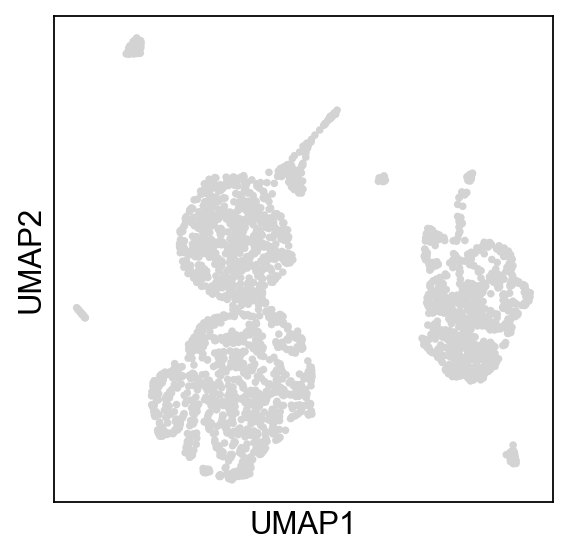

In [98]:
sc.pl.umap(
    adata
)

In [99]:
from matplotlib.colors import ListedColormap
my_cmap1 = ListedColormap(sns.color_palette("Blues").as_hex())
my_cmap2 = sns.color_palette("Paired").as_hex()
my_cmap2[0] = "lightgray"
my_cmap2 = ListedColormap(my_cmap2)

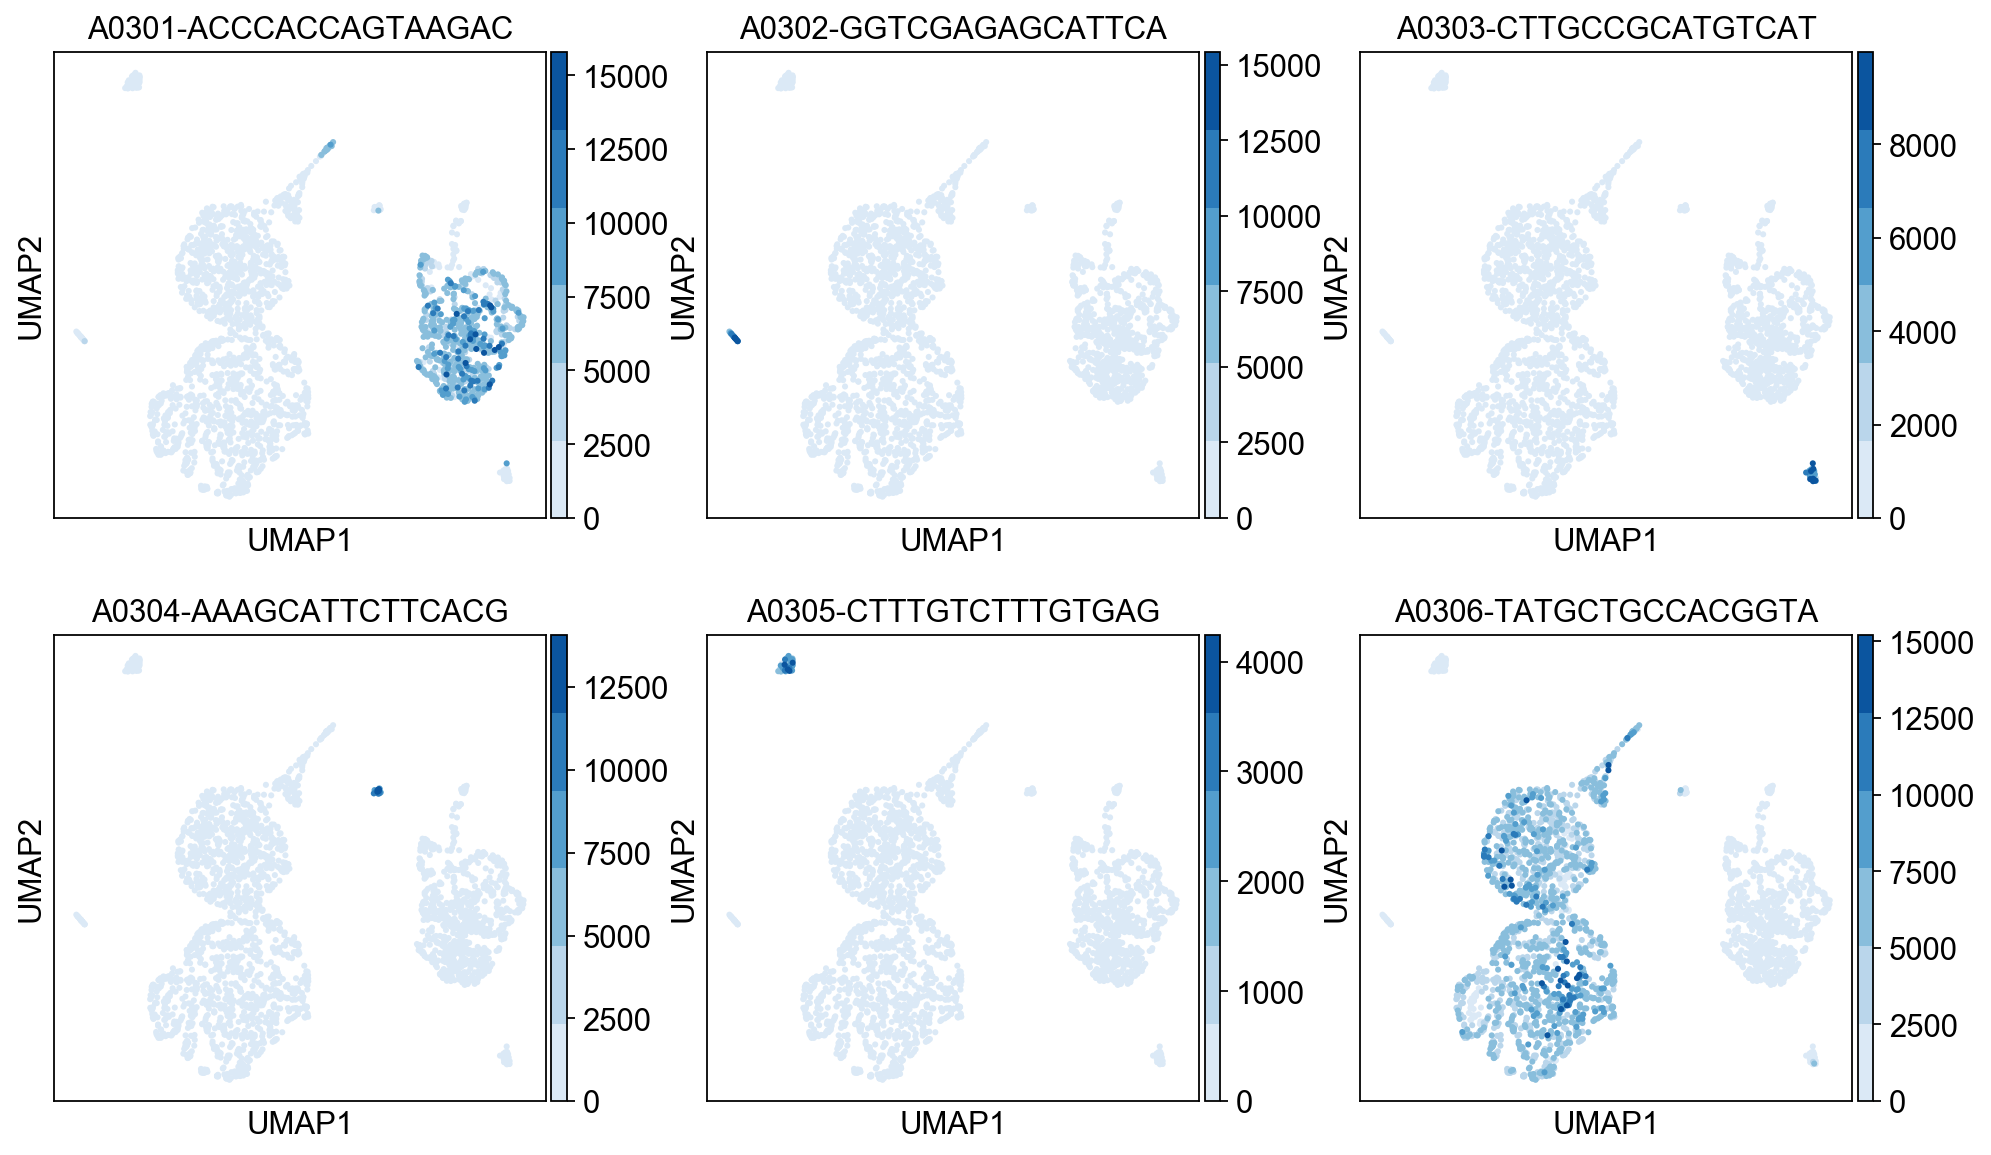

In [100]:
sc.pl.umap(
    adata,
    color=df_umis.columns[:-1],
    color_map=my_cmap1,
    size=30,
    ncols=3,
)

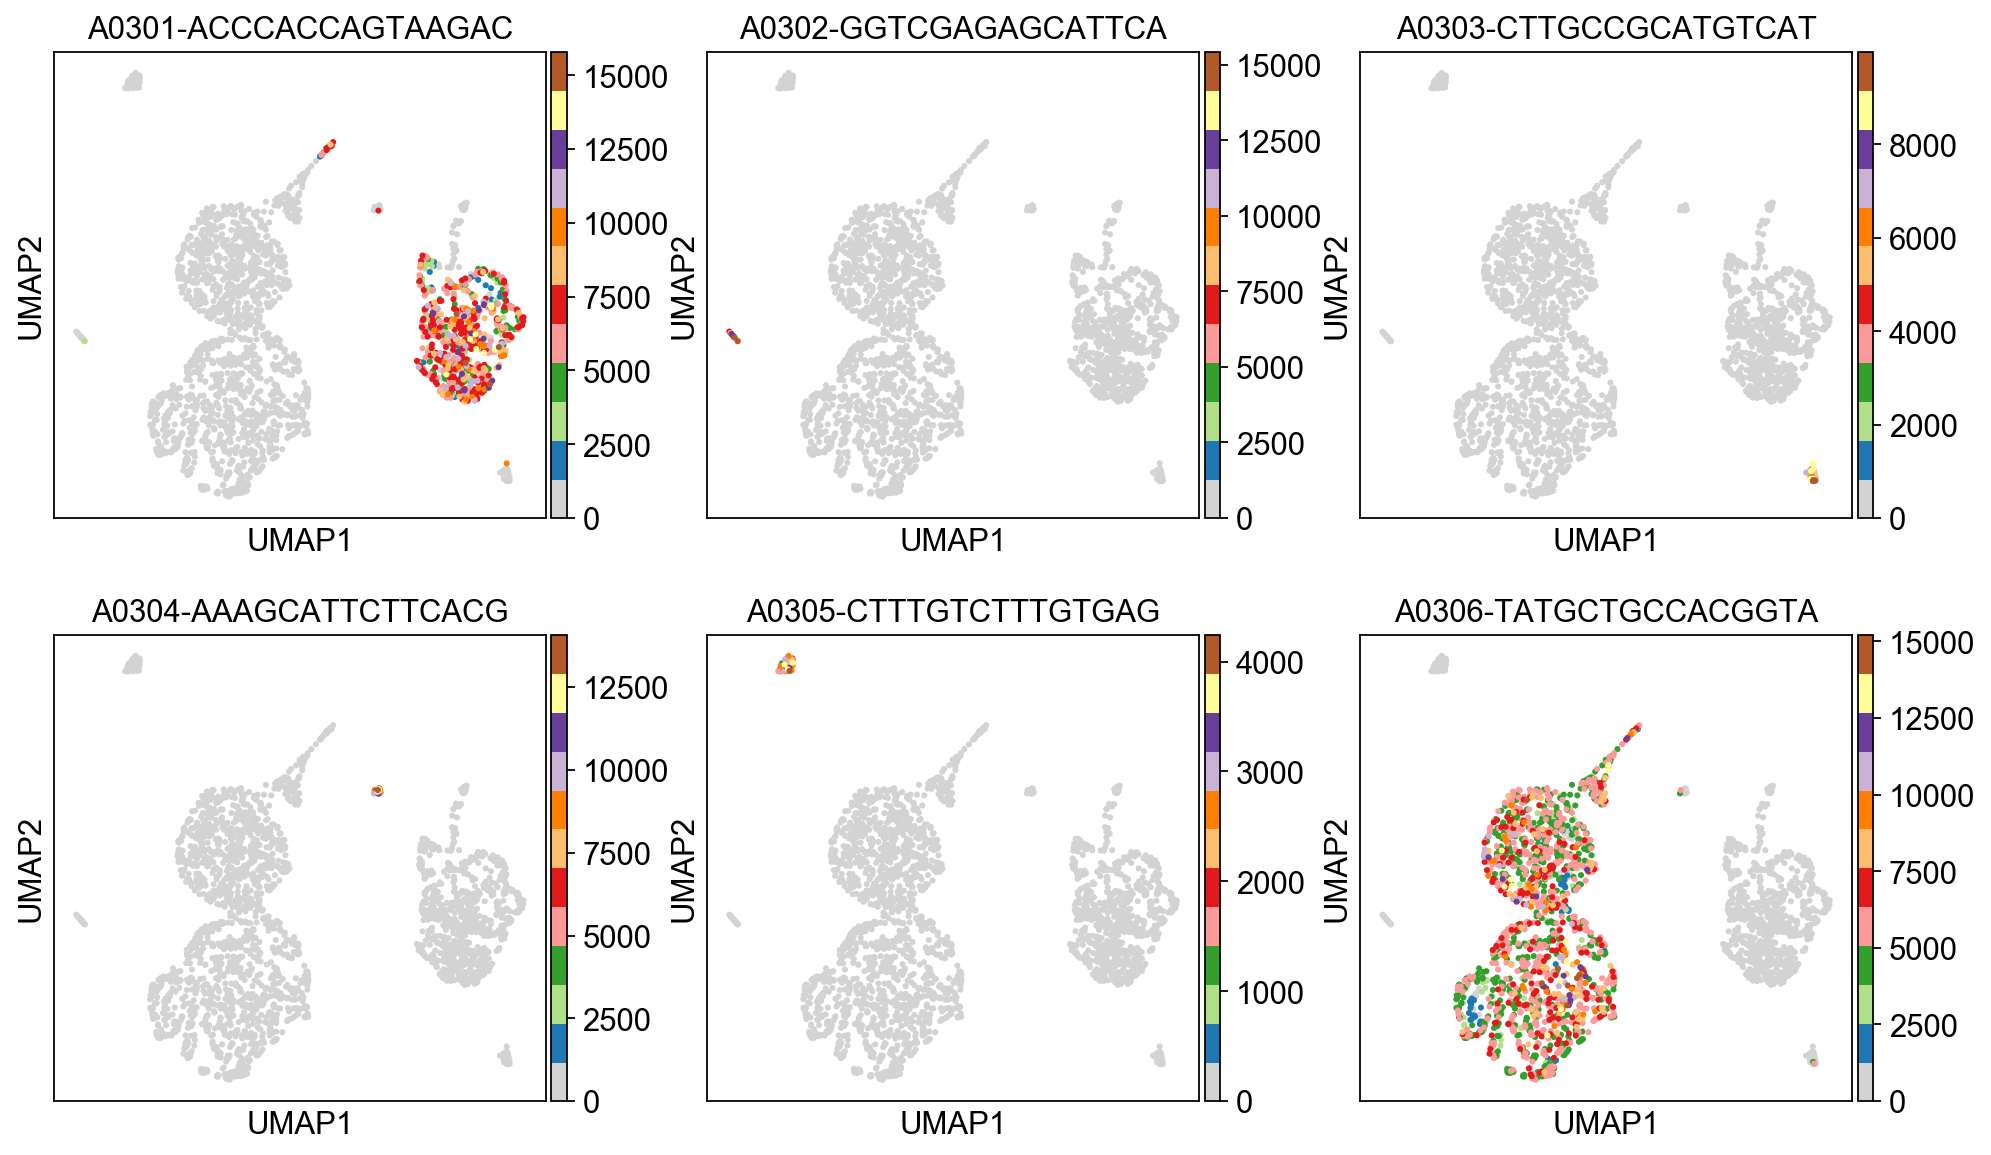

In [101]:
sc.pl.umap(
    adata,
    color=df_umis.columns[:-1],
    color_map=my_cmap2,
    size=30,
    ncols=3,
)

In [102]:
pd.DataFrame(adata.raw.X).sum(axis=1).describe()

count     2572.000000
mean      5749.428223
std       2431.529053
min          0.000000
25%       4596.000000
50%       5462.000000
75%       6616.750000
max      18970.000000
dtype: float64